In [1]:
%%time
import argparse
import numpy as np
import sys, os
import math
import logging
import time
import galsim
import galsim.roman as roman
import datetime
#import fpfs
import pickle


CPU times: user 719 ms, sys: 2.51 s, total: 3.23 s
Wall time: 8.84 s


In [2]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
#import pandas as pd
#from sklearn.ensemble import ExtraTreesRegressor
from astropy.io import fits
from matplotlib.ticker import SymmetricalLogLocator

In [3]:
from scipy.optimize import curve_fit

def fitShear(x, m , c):
    return x*(1 + m ) + c

def getShear(dict_all, norm = False):
    mult_bias_chrom, mult_bias_norm, mult_bias_star = np.zeros(6), np.zeros(6), np.zeros(6)
    add_bias = np.zeros(6)
    R_diff_star, R_diff_scaled = np.zeros(6), np.zeros(6)
    eff_wave, blue_limit, red_limit = np.zeros(6), np.zeros(6), np.zeros(6)
    err_g_star, err_g_chrom, err_g_achrom = np.zeros(6), np.zeros(6), np.zeros(6)
    bin_size = 0.2
    nbins = int(4/bin_size)
    bias_chrom_z, bias_achrom_z, bias_star_z = np.zeros((6, nbins)), np.zeros((6, nbins)), np.zeros((6, nbins))
    min_z = 0
    avg_true_psf, avg_scaled_psf, avg_star_psf = [], [], [] 
    true_psf_fr, scaled_psf_fr, star_psf_fr = [], [], [] 
    for i in range(len(filters)):

        dict_filter = dict_all[filters[i]]
        #add_bias[i] = ratio_factor[i]/1.8*np.average(dict_filter['chrom'][-2] - dict_filter['scaled'][-2])
        #print(add_bias, (np.average(dict_filter['star'][0])/np.average(dict_filter['star'][2])))
        mult_bias_chrom[i] = (np.average(dict_filter['chrom'][0][~np.isnan(dict_filter['chrom'][0])])/np.average(dict_filter['chrom'][2][~np.isnan(dict_filter['chrom'][2])]))
        #mult_bias_achrom[i] = (np.average(dict_filter['achrom'][0])/np.average(dict_filter['achrom'][2])/0.02 -1)
        mult_bias_star[i] = ((np.average(dict_filter['star'][0])/np.average(dict_filter['star'][2])))
        if norm:
            mult_bias_norm[i] = ((np.average(dict_filter['star_norm'][0])/np.average(dict_filter['star_norm'][2])))
        R_diff_star[i] = np.average(dict_filter['chrom'][-1])
        #R_diff_star[i] = np.average(dict_filter['star'][-1]**2 - dict_filter['chrom'][-1]**2)/np.average(dict_filter['chrom'][-1]**2)
        #R_diff_achrom[i] =  np.average(dict_filter['achrom'][-1]**2 - dict_filter['chrom'][-1]**2)/np.average(dict_filter['chrom'][-1]**2)
    dict_info = {'chrom_shear':mult_bias_chrom, 'star_shear':mult_bias_star,'star_norm_shear':mult_bias_norm,
                'R_chrom':R_diff_star}
    return dict_info

In [4]:
def get_bias2(dict_shear,bootstrap = True, z_binning = True, z = None,start_idx = 0, end_idx = 1000, cut = None, mask_ = None):
    num_galaxies = int(len(dict_shear['g1_0'][0][0])/4)
    if cut is None:
        cut = np.ones(num_galaxies, dtype = bool)
    if mask_ is None:
        mask_ = np.ones(num_galaxies, dtype = bool)
    

    shear_corr_e1_all_0, shear_corr_Resp_all_0 = dict_shear['g1_0']
    shear_corr_e1_all_02, shear_corr_Resp_all_02 = dict_shear['g1_02']
    shear_corr_e1_all_n02, shear_corr_Resp_all_n02 = dict_shear['g1_n02']
    num_filt = len(shear_corr_e1_all_02)
    
    mask = np.repeat(mask_, 4)
    mask_temp = []
    for i in range(num_filt):
        mask_temp.append(mask)
    mask = np.array(mask_temp)

    m, c = np.zeros(num_filt), np.zeros(num_filt)
    true_shear = np.array([-0.02,0, 0.02])
    #dict_shear02 = dict_shear02 = getShear(dict_all)
    shear02 = np.nanmean(shear_corr_e1_all_02, axis = 1, where = mask)/np.nanmean(shear_corr_Resp_all_02, axis = 1, where = mask)
    shear0 = np.nanmean(shear_corr_e1_all_0, axis = 1, where = mask)/np.nanmean(shear_corr_Resp_all_0, axis = 1, where = mask)
    shearn02 = np.nanmean(shear_corr_e1_all_n02, axis = 1, where = mask)/np.nanmean(shear_corr_Resp_all_n02, axis = 1, where = mask)
    obs_shear = np.vstack([shearn02, shear0, shear02])#np.vstack([dict_shearn02['chrom_shear'],dict_shearn0['chrom_shear'], dict_shear02['chrom_shear']])
    final_obs_shear = obs_shear.copy()
    for i in range(num_filt):
        popt, pcov = curve_fit(fitShear, true_shear, obs_shear[:, i], p0 = [0, 0])
        m[i], c[i] = popt[0], popt[1]
    
    n_resamples = 500
    


    if z_binning:
        #z = (dict_J129['redshift'])[start_idx:]
        m_corr_z, c_corr_z = [], []
        m_corr_z_avg, c_corr_z_avg = [], []
        m_corr_z_err, c_corr_z_err = [], []
        z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.1]
        #z_bins = [0.0, 0.5, 1.0, 1.5, 2.0, 3.1]
        for j in range(5):
            mask = np.logical_and(z[cut] > z_bins[j], z[cut] < z_bins[j + 1])
            #mask = np.logical_and(mask, mask_)
            print(len(z[cut][mask]))
            mask = np.repeat(mask, 4)
            m_corr, c_corr = np.zeros(num_filt), np.zeros(num_filt)
            true_shear = np.array([-0.02,0, 0.02])
            m_z_boot, c_z_boot = np.zeros(num_filt), np.zeros(num_filt)
            m_z_err_boot, c_z_err_boot = np.zeros(num_filt), np.zeros(num_filt)
            for i in range(num_filt):
                shear02 = np.nanmean(shear_corr_e1_all_02[i][mask])/np.nanmean(shear_corr_Resp_all_02[i][mask])
                shear0 = np.nanmean(shear_corr_e1_all_0[i][mask])/np.nanmean(shear_corr_Resp_all_0[i][mask])
                shearn02 = np.nanmean(shear_corr_e1_all_n02[i][mask])/np.nanmean(shear_corr_Resp_all_n02[i][mask])
                obs_shear = np.array([shearn02, shear0, shear02])
                popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0.0, 0.0])
                m_corr[i], c_corr[i] = popt[0], popt[1]
                #print(m_corr[i])
                m_z_boot[i], c_z_boot[i], m_z_err_boot[i], c_z_err_boot[i] = bootstrap_shear(
                                                 [shear_corr_e1_all_0[i][mask]], [shear_corr_Resp_all_0[i][mask]],
                                                 [shear_corr_e1_all_02[i][mask]], [shear_corr_Resp_all_02[i][mask]], 
                                                 [shear_corr_e1_all_n02[i][mask]], [shear_corr_Resp_all_n02[i][mask]], 
                                                 n_resamples)
                
            m_corr_z.append(m_corr)
            c_corr_z.append(c_corr)
            m_corr_z_avg.append(m_z_boot)
            c_corr_z_avg.append(c_z_boot)
            m_corr_z_err.append(m_z_err_boot)
            c_corr_z_err.append(c_z_err_boot)
        #print(m_corr_z)
        #print(m_corr_z_avg)
            
            
        m_corr_z = np.array(m_corr_z)
        c_corr_z = np.array(c_corr_z)
        m_corr_z_avg = np.array(m_corr_z_avg)
        c_corr_z_avg = np.array(c_corr_z_avg)
        m_corr_z_err = np.array(m_corr_z_err)
        c_corr_z_err = np.array(c_corr_z_err)
        
        #print(m_corr_z)
        #print(m_corr_z_avg)
        boot_info_z = np.array([m_corr_z_avg, c_corr_z_avg, m_corr_z_err, c_corr_z_err])
        #print(boot_info_z[0])
        
    if bootstrap:
        boot_info = bootstrap_shear(shear_corr_e1_all_0, shear_corr_Resp_all_0,
                                                 shear_corr_e1_all_02, shear_corr_Resp_all_02, 
                                                 shear_corr_e1_all_n02, shear_corr_Resp_all_n02, 
                                                 n_resamples,)
        
        dict_return = {'m':m, 'c':c, 'm_z':m_corr_z, 'c_z':c_corr_z,
                      'obs_shear':final_obs_shear, 'm_err': boot_info[2],'c_err': boot_info[3],
                       'm_err_z':boot_info_z[2], 'c_err_z':boot_info_z[3]}
        #return m,c, m_corr_z, c_corr_z, final_obs_shear, boot_info, boot_info_z
        return dict_return
    
    return m,c, m_corr_z, c_corr_z, final_obs_shear
    

In [5]:
def get_dict_shear(batches, dir_, etr = False, roman_only = False, add_ = ""):
    g_list = ['g1_0', 'g1_02', 'g1_n02']
    dict_comb = {}
    add = add_
    if etr:
        add = "YJHF_" + add_
        if roman_only:
            add += "YJHF_romanonly_"
    for g in g_list:
        dict_comb[g] = []
        for batch in batches:
            pickle_in = open(dir_ + "Shear_" + add +batch + '.pickle',"rb")
            dict_shear_ = pickle.load(pickle_in)
            pickle_in.close()
            if batch == batches[0]:
                temp_e = dict_shear_[g][0]
                temp_R = dict_shear_[g][1]
            else:
                temp_e = np.hstack([temp_e ,dict_shear_[g][0]] )
                temp_R = np.hstack([temp_R ,dict_shear_[g][1]] )
        dict_comb[g].append(temp_e )
        dict_comb[g].append(temp_R )
    return dict_comb

In [6]:
def bootstrap_shear(e1_0, R_0, e1_02, R_02, e1_n02, R_n02, n_resamples, seed = 999):
    num_gal = int(len(e1_0[0])/4)
    indices = np.arange(num_gal)
    num_filt = len(e1_0)
    np.random.seed(seed)
    m_boot, c_boot = np.zeros((n_resamples, num_filt)), np.zeros((n_resamples, num_filt))
    for i in range(n_resamples):
        m, c = np.zeros(num_filt), np.zeros(num_filt)
        for j in range(num_filt):
            rand_idx = 4*np.random.choice(indices, size = int(num_gal) )
            e1_0_sample = np.hstack([e1_0[j][rand_idx], e1_0[j][rand_idx + 1], e1_0[j][rand_idx + 2], e1_0[j][rand_idx + 3]]).flatten()
            e1_02_sample = np.hstack([e1_02[j][rand_idx], e1_02[j][rand_idx + 1], e1_02[j][rand_idx + 2], e1_02[j][rand_idx + 3]]).flatten()
            e1_n02_sample = np.hstack([e1_n02[j][rand_idx], e1_n02[j][rand_idx + 1], e1_n02[j][rand_idx + 2], e1_n02[j][rand_idx + 3]]).flatten()

            R_0_sample = np.hstack([R_0[j][rand_idx], R_0[j][rand_idx + 1], R_0[j][rand_idx + 2], R_0[j][rand_idx + 3]]).flatten()
            R_02_sample = np.hstack([R_02[j][rand_idx], R_02[j][rand_idx + 1], R_02[j][rand_idx + 2], R_02[j][rand_idx + 3]]).flatten()
            R_n02_sample = np.hstack([R_n02[j][rand_idx], R_n02[j][rand_idx + 1], R_n02[j][rand_idx + 2], R_n02[j][rand_idx + 3]]).flatten()
            m[j], c[j] = get_m_c(e1_0_sample,R_0_sample, e1_02_sample, R_02_sample, e1_n02_sample, R_n02_sample  )
        m_boot[i], c_boot[i] = m, c
    m_avg, c_avg = np.mean(m_boot, axis = 0), np.mean(c_boot, axis = 0)
    m_std, c_std = np.std(m_boot, axis = 0, ddof = 1), np.std(c_boot, axis = 0, ddof = 1)
    #print(m_avg)
    if num_filt == 1:
        return m_avg[0], c_avg[0], m_std[0], c_std[0]
    return m_avg, c_avg, m_std, c_std

In [7]:
def get_m_c (e1_0, R_0, e1_02, R_02, e1_n02, R_n02):
    #m, c = np.zeros(6), np.zeros(6)
    true_shear = np.array([-0.02,0, 0.02])
    #dict_shear02 = dict_shear02 = getShear(dict_all)
    shear02 = np.mean(e1_02)/np.mean(R_02)
    shear0 = np.mean(e1_0)/np.mean(R_0)
    shearn02 = np.mean(e1_n02)/np.mean(R_n02)
    obs_shear = np.array([shearn02, shear0, shear02])#np.vstack([dict_shearn02['chrom_shear'],dict_shearn0['chrom_shear'], dict_shear02['chrom_shear']])
    final_obs_shear = obs_shear.copy()
    popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])
    m, c = popt[0], popt[1]
    return m,c

In [8]:
def get_pos(dir_):
    #pickle_in = open('10000Gal_NoNoise_J129_RealisticSEDs_g10_g20.pickle', "rb")
    with open(dir_ + 'J129/gal_info.pickle', "rb") as pickle_in:
        # Load only necessary parts if possible
        data = pickle.load(pickle_in)
        dict_J129 = data[['SCA', 'x_pos', 'y_pos', 'redshift','galaxy_id']]
    #dict_J129 = pickle.load(pickle_in)['gal_df'][['SCA', 'x_pos', 'y_pos']]
    pickle_in.close()
    SCAs = dict_J129['SCA'].to_numpy()
    x_pos = (dict_J129['x_pos']).to_numpy()
    y_pos = (dict_J129['y_pos']).to_numpy()
    z = (dict_J129['redshift']).to_numpy()
    gal_ids = (dict_J129['galaxy_id']).to_numpy()
    del dict_J129
    del data
    return gal_ids,SCAs, x_pos, y_pos, z

In [9]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

#mpl.rcParams['font.family']='serif'
#cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
#mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext']=True

from matplotlib import rcParams
rcParams.update({'font.family': 'serif', 'mathtext.fontset': 'dejavuserif',
                 'font.size': 12, 'text.latex.preamble': r"\usepackage{amsmath}",
                 'xtick.major.pad': 2, 'ytick.major.pad': 2, 'xtick.major.size': 6, 'ytick.major.size': 6,
                 'xtick.minor.size': 3, 'ytick.minor.size': 3, 'axes.linewidth': 2, 'axes.labelpad': 1})

In [10]:
use_filters = 'YJHFKW'
roman_filters = roman.getBandpasses(AB_zeropoint=True)

# Get the names of the ones we will use here.
filters = [filter_name for filter_name in roman_filters if filter_name[0] in use_filters]

filters_copy = filters.copy()
filters_copy[4] = filters_copy[5]
filters_copy[5] = filters[4]
filters = filters_copy

blue_limit, red_limit, eff_wave = np.zeros(6), np.zeros(6), np.zeros(6)
for i in range(0,len(filters)):

    bandpass = roman_filters[filters[i]]
    eff_wave[i] = bandpass.effective_wavelength
    blue_limit[i], red_limit[i] = bandpass.blue_limit, bandpass.red_limit
    sampling_rate = (eff_wave[i]/1e3)*7.9/10
    print(filters[i] + ': %.2f'%sampling_rate )

Y106: 0.84
J129: 1.02
H158: 1.25
F184: 1.46
K213: 1.68
W146: 1.16


### Starts here

In [1]:
z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.1]
z_mid = (z_bins[:-1] + z_bins[1:])/2

In [11]:
dir_ = 'sim_images/10000Gal_NoNoise_diffsky/'
gal_ids_diff, SCAs, x_pos, y_pos, z_diffsky = get_pos(dir_)

dir_ = 'sim_images/10000Gal_NoNoise_cosmoDC2_final/'
gal_ids_cd2, SCAs, x_pos, y_pos, z_cd2 = get_pos(dir_)

In [12]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/StarPSF/"
dict_comb = get_dict_shear(batches, dir_)

In [13]:
star_bias = get_bias2(dict_comb, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2087
2103
1913
1853


In [14]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/StarPSF/"
dict_comb = get_dict_shear(batches, dir_ )

In [15]:
star_bias_cd2 = get_bias2(dict_comb, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
2462
2411
1910
1247


In [22]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/TruePSF/"
dict_comb = get_dict_shear(batches, dir_)

In [23]:
true_bias = get_bias2(dict_comb, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2087
2103


/tmp/ipykernel_2376539/1712427547.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])


1913
1853


In [24]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/TruePSF/"
dict_comb = get_dict_shear(batches, dir_ )

In [25]:
true_bias_cd2 = get_bias2(dict_comb, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
2462
2411
1910
1247


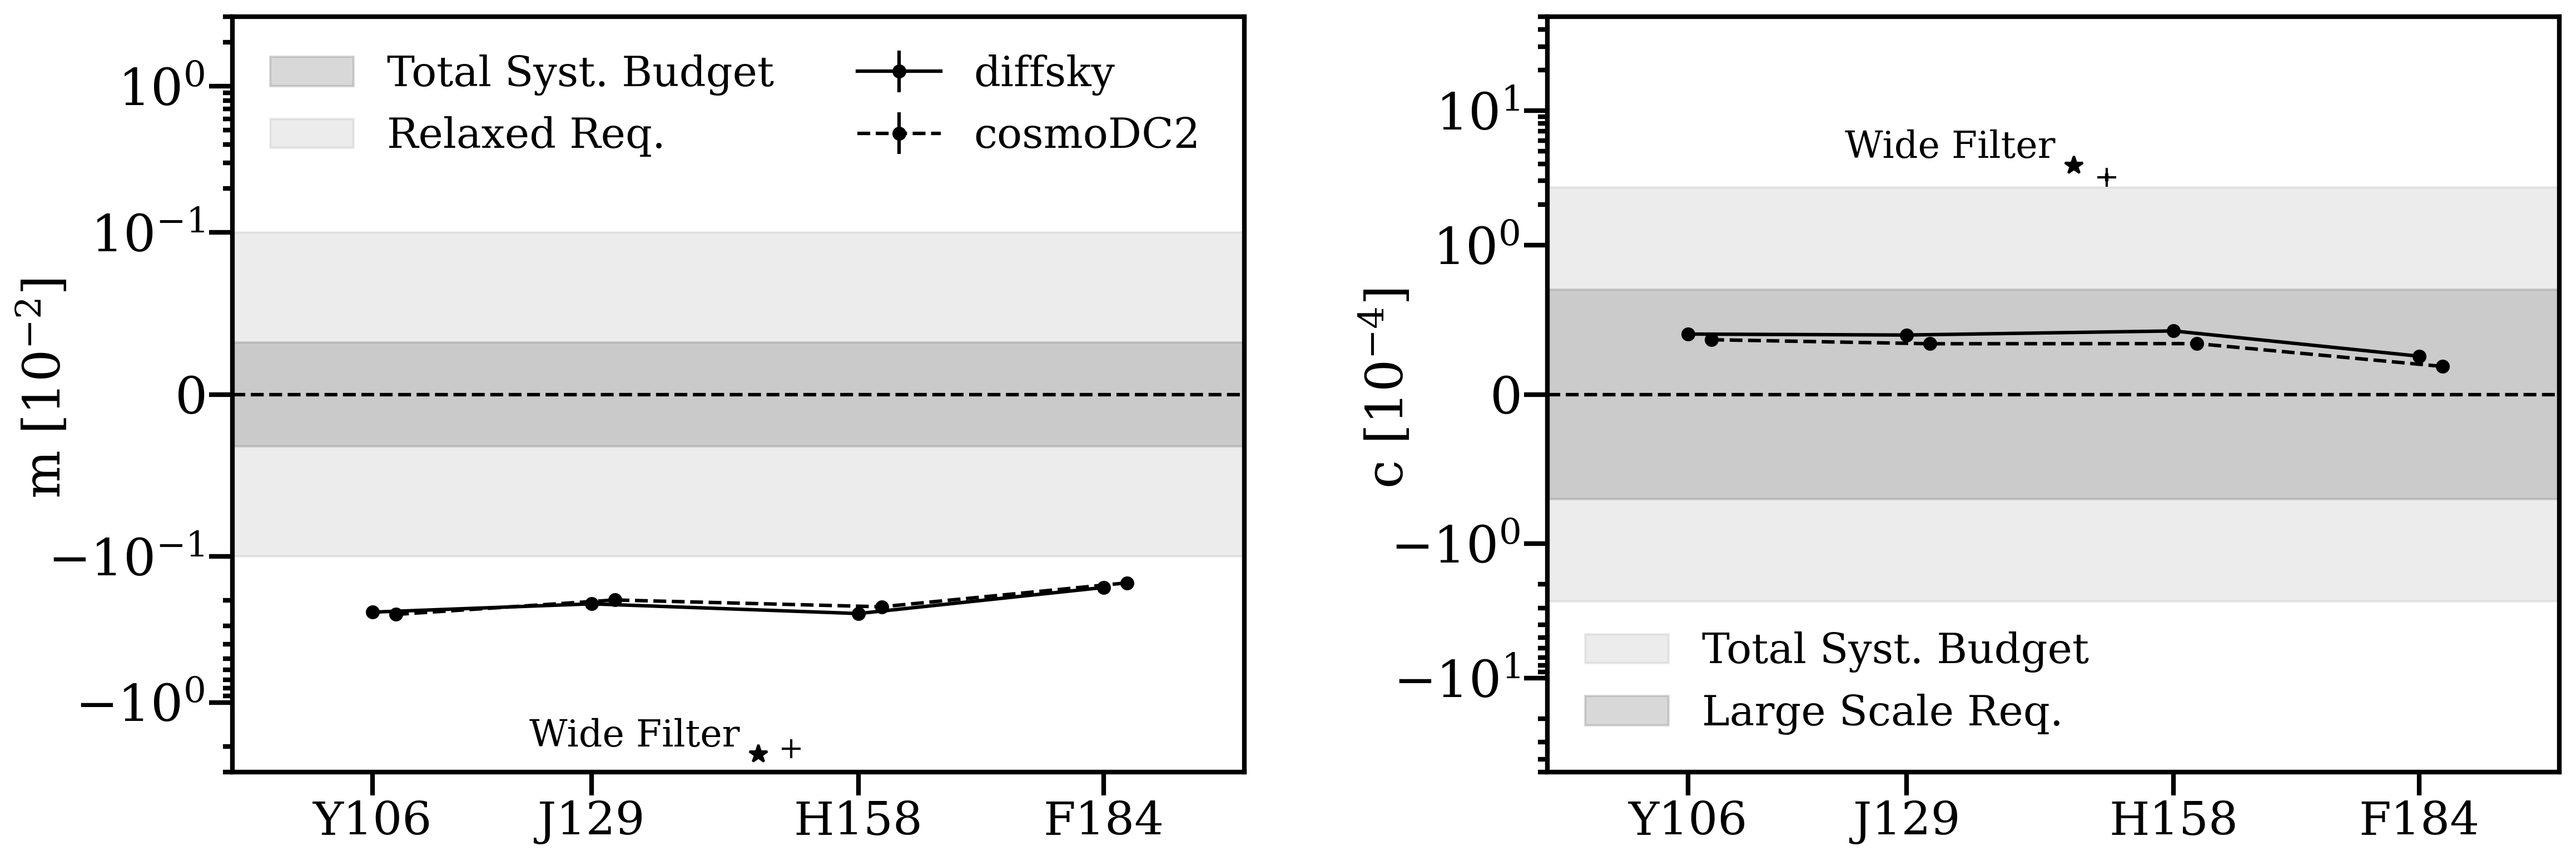

In [25]:
fig, axs = plt.subplots(figsize=(18,6),dpi=300, nrows=1, ncols=2, sharex=True, sharey=False)
fig.subplots_adjust(wspace=0.3, hspace=1.20)
custom_labels = [ 'Y106', 'J129', 'H158', 'F184']
#axs[0].scatter(eff_wave[:4], star_bias['m'][:4]*1e2, color = 'black',s = 5)
axs[0].fill_between([600,2000], y1 = -3.2*1e-2, y2 = 3.2*1e-2, color = 'grey', alpha = 0.3, label = r'Total Syst. Budget'  )
axs[0].fill_between([600,2000], y1 = -0.1, y2 = 0.1, color = 'grey', alpha = 0.15 , label = 'Relaxed Req.')

#axs[0].plot(eff_wave[:4], star_bias['m'][:4]*1e2, color = 'black',marker = 'o',markersize = 5, label = 'diffsky')
axs[0].errorbar(eff_wave[:4], star_bias['m'][:4]*1e2, yerr=star_bias['m_err'][:4]*1e2, fmt='-o', color='black', markersize=5, capsize=0,  label = 'diffsky')
axs[0].errorbar(eff_wave[:4] + 25, star_bias_cd2['m'][:4]*1e2, yerr=star_bias_cd2['m_err'][:4]*1e2, fmt='--o', color='black', markersize=5, capsize=0,  label = 'cosmoDC2')
#fig.subplots_adjust(wspace=0.0, hspace=0.20)
#axs[0] = plot_m_z(m_true,  axs[0], np.zeros(7), color = 'purple', offset = 0)
axs[0].errorbar(eff_wave[-1], star_bias['m'][-1]*1e2, yerr=star_bias['m_err'][-1]*1e2, fmt='*', color='black', markersize=8, capsize=0)
axs[0].errorbar(eff_wave[-1] + 35, star_bias_cd2['m'][-1]*1e2, yerr=star_bias_cd2['m_err'][-1]*1e2, fmt='+', color='black', markersize=8, capsize=0)
#axs[0].scatter(eff_wave[-1],star_bias['m'][-1]*1e2, color = 'black',marker = '*')
#axs[0].scatter(eff_wave[-1]+25,star_bias_cd2['m'][-1]*1e2, color = 'black',marker = '+')
#axs[0].scatter(eff_wave[-1], m_true[-1]*1e2, color = 'purple',marker = '*')
axs[0].text(eff_wave[-1] - 20, star_bias['m'][-1]*1e2, 'Wide Filter', fontsize=16, verticalalignment='bottom', horizontalalignment='right')
axs[0].set_ylabel(r' m [$10^{-2}$] ', fontsize = 22, labelpad=-10)
axs[0].set_ylim(-3, 3)
axs[0].set_yscale('symlog', linthresh=0.1)
axs[0].tick_params('both', length=10, width=2,labelsize=22, which='major')
axs[0].tick_params('both', length=10, width=2,labelsize=22, which='minor')
axs[0].yaxis.set_major_locator(SymmetricalLogLocator(base=10, linthresh=0.1))
axs[0].yaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=0.1, subs=[1, 2, 3, 4, 5, 6, 7, 8, 9]))
axs[0].tick_params(axis='y', which='minor', length=4)
axs[0].axhline( y = 0, color = 'black', ls = '--')

axs[0].set_xlim(1000,1900)
axs[0].set_xticks(eff_wave[:-2])
axs[0].set_xticklabels(custom_labels, fontsize = 20)
axs[0].legend(loc = 'upper left', frameon = False, ncol = 2, fontsize = 18)


axs[0].set_xlim(eff_wave[0] - 150, eff_wave[3] + 150)



#axs[0].scatter(eff_wave[:4], star_bias['m'][:4]*1e2, color = 'black',s = 5)
axs[1].fill_between([600,2000], y1 = -2.7, y2 = 2.7, color = 'grey', alpha = 0.15, label = r'Total Syst. Budget'  )
axs[1].fill_between([600,2000], y1 = -0.7, y2 = 0.7, color = 'grey', alpha = 0.3 , label = 'Large Scale Req.')

axs[1].errorbar(eff_wave[:4], star_bias['c'][:4]*1e4, yerr=star_bias['c_err'][:4]*1e4, fmt='-o', color='black', markersize=5, capsize=0)
axs[1].errorbar(eff_wave[:4] + 25, star_bias_cd2['c'][:4]*1e4, yerr=star_bias_cd2['c_err'][:4]*1e4, fmt='--o', color='black', markersize=5, capsize=0)
#axs[1].plot(eff_wave[:4], star_bias['c'][:4]*1e4, color = 'black',marker = 'o',markersize = 5)
#axs[1].plot(eff_wave[:4]+25, star_bias_cd2['c'][:4]*1e4, color = 'black',marker = 'o',ls = '--',markersize = 5)
#fig.subplots_adjust(wspace=0.0, hspace=0.20)
#axs[0] = plot_m_z(m_true,  axs[0], np.zeros(7), color = 'purple', offset = 0)
axs[1].errorbar(eff_wave[-1], star_bias['c'][-1]*1e4, yerr=star_bias['c_err'][-1]*1e4, fmt='*', color='black', markersize=8, capsize=0)
axs[1].errorbar(eff_wave[-1] + 35, star_bias_cd2['c'][-1]*1e4, yerr=star_bias_cd2['c_err'][-1]*1e4, fmt='+', color='black', markersize=8, capsize=0)
#axs[1].scatter(eff_wave[-1],star_bias['c'][-1]*1e4, color = 'black',marker = '*')
#axs[1].scatter(eff_wave[-1] + 25,star_bias_cd2['c'][-1]*1e4, color = 'black',marker = '+')
#axs[0].scatter(eff_wave[-1], m_true[-1]*1e2, color = 'purple',marker = '*')
axs[1].text(eff_wave[-1] - 20, star_bias['c'][-1]*1e4, 'Wide Filter', fontsize=16, verticalalignment='bottom', horizontalalignment='right')
axs[1].set_ylabel(r' c [$10^{-4}$] ', fontsize = 22, labelpad=-10)
axs[1].set_ylim(-50, 50)
axs[1].set_yscale('symlog', linthresh=1)
axs[1].tick_params('both', length=10, width=2,labelsize=22, which='major')
axs[1].tick_params('both', length=10, width=2,labelsize=22, which='minor')
axs[1].yaxis.set_major_locator(SymmetricalLogLocator(base=10, linthresh=1))
axs[1].yaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=1, subs=[1, 2, 3, 4, 5, 6, 7, 8, 9]))
axs[1].tick_params(axis='y', which='minor', length=4)
axs[1].axhline( y = 0, color = 'black', ls = '--')

axs[1].set_xlim(1000,1900)
axs[1].set_xticks(eff_wave[:-2])
axs[1].set_xticklabels(custom_labels, fontsize = 20)
axs[1].legend(loc = 'lower left', frameon = False, ncol = 1, fontsize = 18)


axs[1].set_xlim(eff_wave[0] - 150, eff_wave[3] + 150)
save = True
if save:
    plt.savefig('PaperFigures/uncorrbias.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


In [73]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/TrueCorrPSF/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_true = get_dict_shear(batches, dir_, add_ = '')

In [74]:
star_bias_corr = get_bias2(dict_comb_true, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2044
2087
2087
2103
2103
1913
1913
1853
1853


In [75]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
#batches = ['3000_3999','4000_4999','5000_5999','6000_6999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/TrueCorrPSF/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb = get_dict_shear(batches, dir_)

In [76]:
star_bias_corr_cd2 = get_bias2(dict_comb, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462
2411
2411


/tmp/ipykernel_1149265/1712427547.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])
/tmp/ipykernel_1149265/1712427547.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])


1910
1910
1247
1247


In [77]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/TrueAvgCorrPSF/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_avg = get_dict_shear(batches, dir_, add_ = '')

In [78]:
#mask_ = np.logical_and(z_diffsky > z_bins[0], z_diffsky < z_bins[0 + 1])
#maskz_ = np.logical_and(coeff_diff['H158'] > coeff_z_mean[0] - 8e-7 ,coeff_diff['H158'] < coeff_z_mean[0]+ 8e-7 )
#mask_ = np.logical_and(mask_, maskz_)
star_bias_avgcorr = get_bias2(dict_comb_avg, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2044
2087
2087
2103
2103
1913
1913
1853
1853


In [79]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/TrueAvgCorrPSF/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb = get_dict_shear(batches, dir_)

In [80]:
star_bias_avgcorr_cd2 = get_bias2(dict_comb, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462


/tmp/ipykernel_1149265/1712427547.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])
/tmp/ipykernel_1149265/1712427547.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])


2411
2411
1910
1910
1247
1247


In [81]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/TrueAvgCorrPSF_zbin/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb = get_dict_shear(batches, dir_, add_ = '')

In [82]:
#mask_ = np.logical_and(z_diffsky > z_bins[0], z_diffsky < z_bins[0 + 1])
#maskz_ = np.logical_and(coeff_diff['H158'] > coeff_z_mean[0] - 2.5e-6 ,coeff_diff['H158'] < coeff_z_mean[0]+ 2.5e-6 )
#mask_ = np.logical_and(mask_, maskz_)
star_bias_avgzcorr = get_bias2(dict_comb, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2044
2087
2087
2103
2103
1913
1913
1853
1853


In [83]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/TrueAvgCorrPSF_zbin/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb = get_dict_shear(batches, dir_)

In [84]:
star_bias_avgzcorr_cd2 = get_bias2(dict_comb, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000 )

1970
1970
2462
2462
2411
2411
1910
1910
1247
1247


In [86]:
def abs_max(arr, arr_err = None):
    max_ = np.max(arr, axis = 0)
    min_ = np.min(arr, axis = 0)
    abs_max = []
    abs_max_err = []
    for i in range(len(max_)):
        if abs(max_[i]) > abs(min_[i]):
            abs_max.append(max_[i])
        else:
            abs_max.append(min_[i]) 
    if arr_err is not None:
        for i in range(len(abs_max)):
            idxs = np.where(arr ==abs_max[i])
            row, col = idxs[0][0], idxs[1][0]
            abs_max_err.append(arr_err[row][col])
        return np.array(abs_max_err)
    return np.array(abs_max)

In [71]:
# Function to plot a single subplot with error bars and lines
def plot_subplot(ax, y_values_dict, y_values_cd2_dict, y_values_err_dict, y_values_cd2_err_dict,x_vals,
                 title, ylabel, ylim, yscale_linthresh, fill_between_vals,fill_between_xvals, legend_labels,
                 fill_legend=True, legend=True, right_ticks=False, fact=1e2, cd2_label='', offset_cd2 = 15,
                 xlim_offset = 150, custom_labels = None, colors = None, colors_cd2 = None, legend_size =21 ,
                 legend_loc ='upper left', label_fontsize = 24, xlabel = None , tick_labelsize = 22, ncol = None,
                 legend_labels_cd2 = None, lw = 2):
    """
    Plots a subplot with given data, error bars, and formatting options.
    """
    # Add shaded systematic budget regions
    if fill_legend:
        if fact == 1e2:
            ax.fill_between(fill_between_xvals, y1=fill_between_vals[0], y2=fill_between_vals[1], color='grey', alpha=0.3, label='Total Syst. Budget')
            ax.fill_between(fill_between_xvals, y1=fill_between_vals[2], y2=fill_between_vals[3], color='grey', alpha=0.15, label='Relaxed Requirement')
        if fact == 1e4:
            ax.fill_between(fill_between_xvals, y1=fill_between_vals[0], y2=fill_between_vals[1], color='grey', alpha=0.3, label='Large Scale Requirement')
            ax.fill_between(fill_between_xvals, y1=fill_between_vals[2], y2=fill_between_vals[3], color='grey', alpha=0.15, label='Total Syst. Budget')

    else:
        ax.fill_between(fill_between_xvals, y1=fill_between_vals[0], y2=fill_between_vals[1], color='grey', alpha=0.3)
        ax.fill_between(fill_between_xvals, y1=fill_between_vals[2], y2=fill_between_vals[3], color='grey', alpha=0.15)

    # Define colors and linestyles
    if colors is None:
        colors = ['black', 'blue', 'red', 'orange']
    linestyles = ['-', '--']
    if colors_cd2 is None:
        colors_cd2 = colors
    # Plot data with error bars (now also including the connecting lines)
    if legend_labels_cd2 is None:
        legend_labels_cd2 = ['']*len(colors_cd2)
    for (key, y_values),  (key_err, y_errors),  color, label in zip(
            y_values_dict.items(),  y_values_err_dict.items(), colors, legend_labels):
        
        # Regular (solid line with markers and error bars)
        ax.errorbar(x_vals, y_values * fact, yerr=y_errors * fact, fmt='-o', color=color, markersize=5, capsize=0, label=label, lw = lw)

    
    for (key_cd2, y_values_cd2), (key_cd2_err, y_errors_cd2), color, label in zip(
            y_values_cd2_dict.items(), y_values_cd2_err_dict.items(), colors_cd2, legend_labels_cd2):

        # Dashed (_cd2) version
        if color == 'black':
            ax.errorbar(x_vals+offset_cd2, y_values_cd2 * fact, yerr=y_errors_cd2 * fact, fmt='--o', color=color, markersize=5, capsize=0, label=cd2_label, lw = lw)
        else:
            ax.errorbar(x_vals+offset_cd2, y_values_cd2 * fact, yerr=y_errors_cd2 * fact, fmt='--o', color=color, markersize=5, capsize=0, label = label, lw = lw )

    # Axes settings
    ax.set_title(title, fontsize=24)
    ax.set_xlim(x_vals[0] - xlim_offset, x_vals[-1] + xlim_offset)
    if custom_labels is not None:
        ax.set_xticks(eff_wave[:-2])
        ax.set_xticklabels(custom_labels, fontsize=20)
    ax.set_ylim(ylim)
    ax.set_yscale('symlog', linthresh=yscale_linthresh)

    ax.tick_params(axis='both', length=10, width=2, labelsize=tick_labelsize, which='major')
    ax.tick_params(axis='both', length=10, width=2, labelsize=tick_labelsize, which='minor')
    ax.yaxis.set_major_locator(SymmetricalLogLocator(base=10, linthresh=yscale_linthresh))
    ax.yaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=yscale_linthresh, subs=np.arange(1, 10)))
    ax.tick_params(axis='y', which='minor', length=4)
    ax.axhline(y=0, color='black', ls='--')

    # Y-axis settings
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=label_fontsize, labelpad=-10)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=label_fontsize, labelpad=10)

    # Move ticks to right if needed
    if right_ticks:
        ax.tick_params(axis='y', which='minor', length=4, right=True, labelright=True, left=False, labelleft=False)
        ax.tick_params(axis='y', which='major', length=4, right=True, labelright=True, left=False, labelleft=False)

    # Legend settings
    if legend:
        if ncol is None:
            ax.legend(loc=legend_loc, frameon=False, ncol=2 if (len(legend_labels[0]) > 0) else 1, fontsize=legend_size)
        else:
            ax.legend(loc=legend_loc, frameon=False, ncol=ncol, fontsize=legend_size)

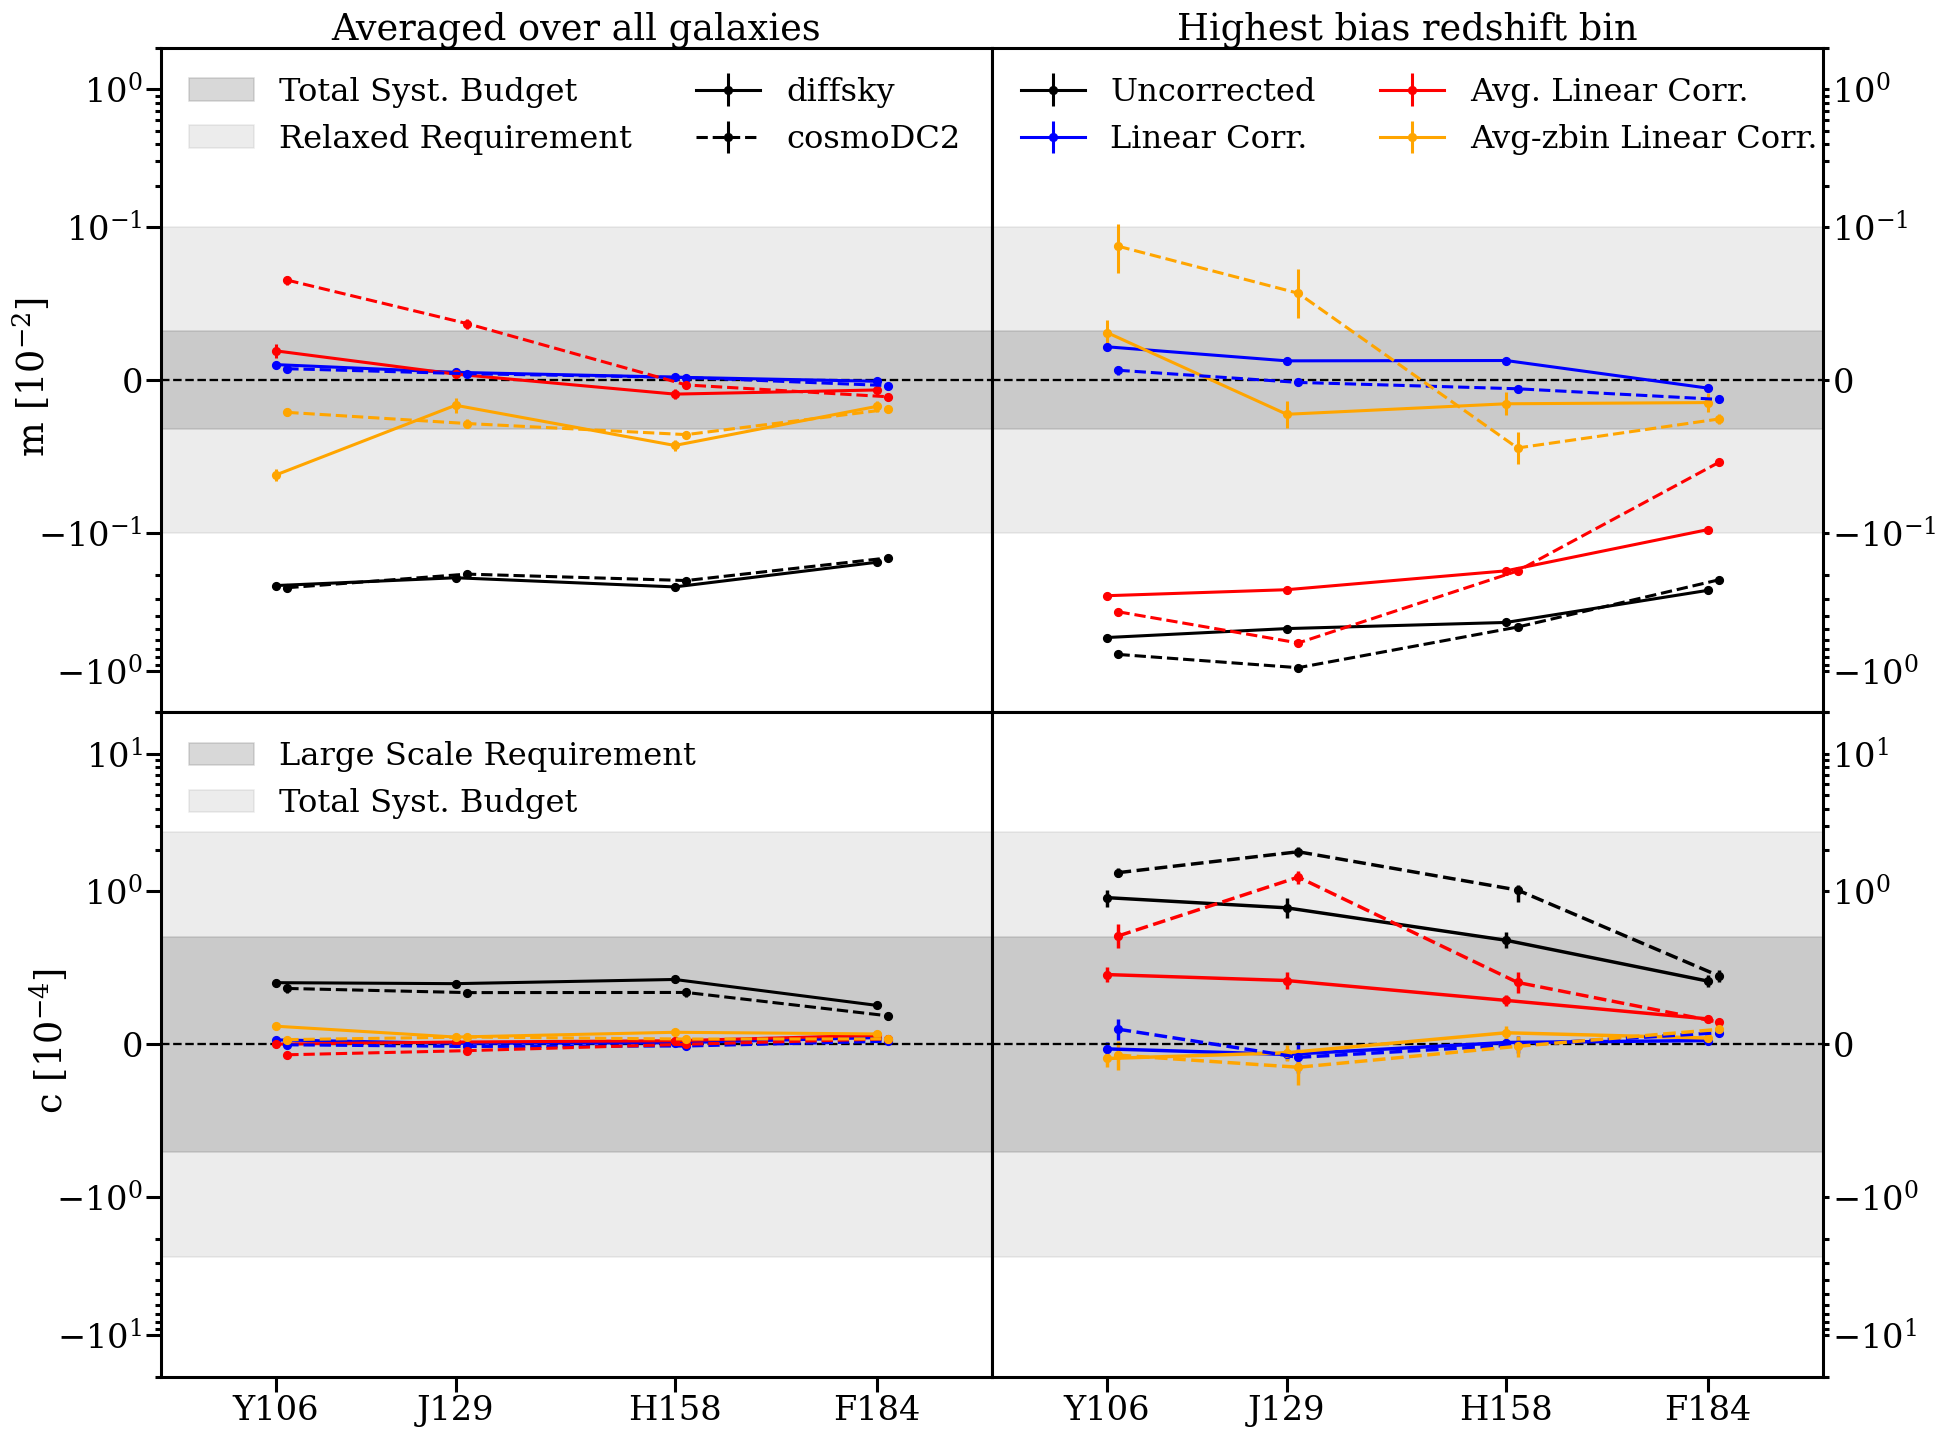

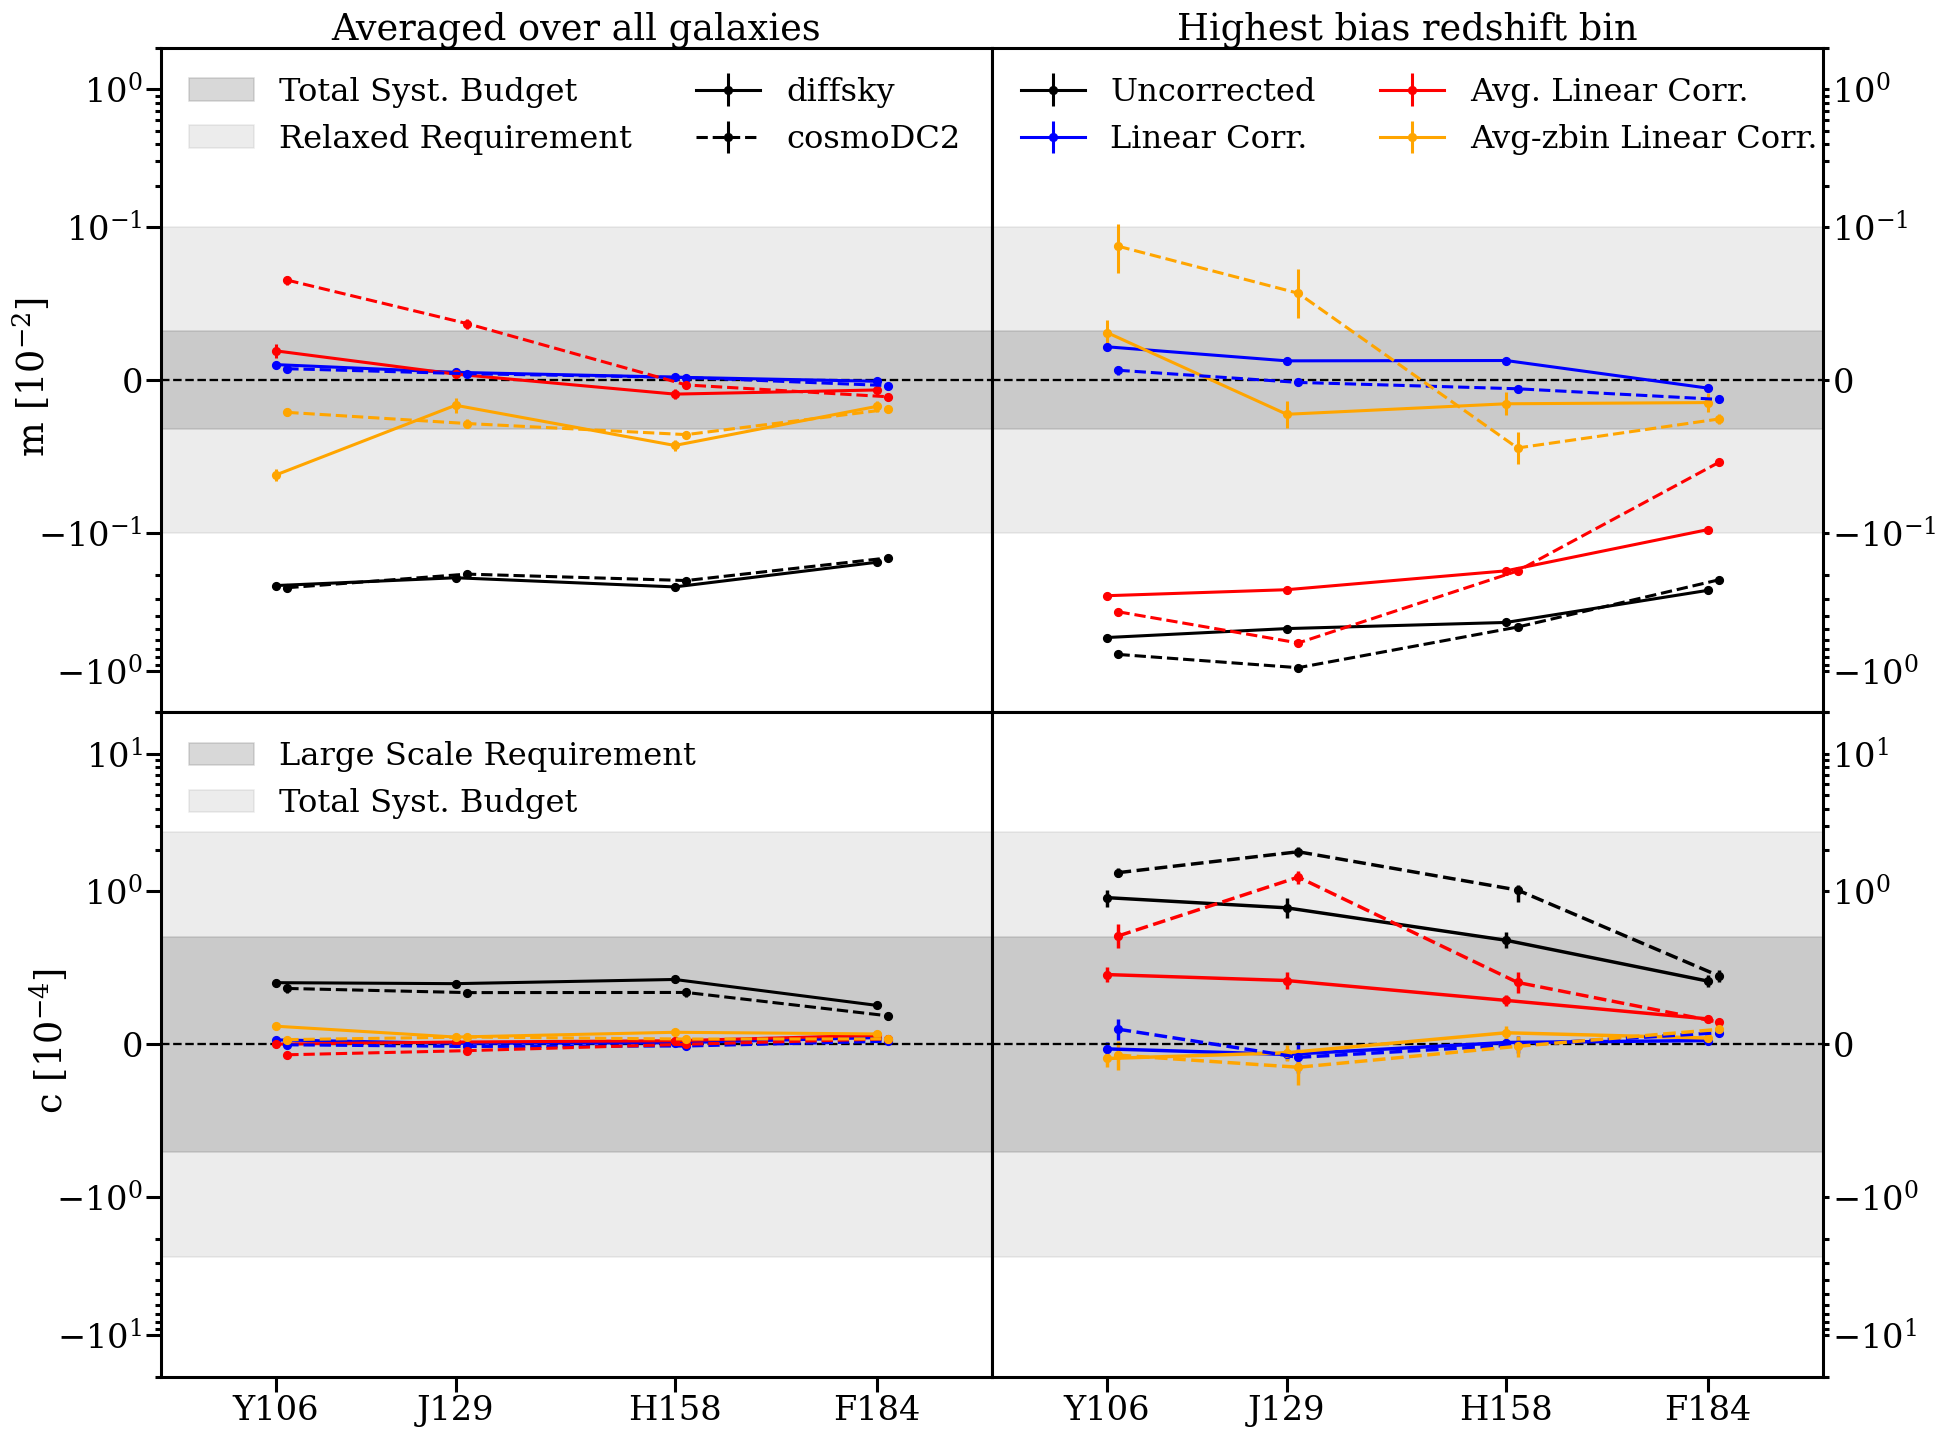

In [95]:


# Create figure and subplots
fig, axs = plt.subplots(figsize=(19.5,16), dpi=110, nrows=2, ncols=2, sharex=True, sharey=False)
axs = axs.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

custom_labels = ['Y106', 'J129', 'H158', 'F184']

#  Subplot 1: Averaged over all galaxies
plot_subplot(
    ax=axs[0],
    y_values_dict={
        'm': star_bias['m'][:4],
        'corr': star_bias_corr['m'][:4],
        'avgcorr': star_bias_avgcorr['m'][:4],
        'avgzcorr': star_bias_avgzcorr['m'][:4]
    },
    y_values_cd2_dict={
        'm': star_bias_cd2['m'][:4],
        'corr': star_bias_corr_cd2['m'][:4],
        'avgcorr': star_bias_avgcorr_cd2['m'][:4],
        'avgzcorr': star_bias_avgzcorr_cd2['m'][:4]
    },
    y_values_err_dict={
        'm': star_bias['m_err'][:4],
        'corr': star_bias_corr['m_err'][:4],
        'avgcorr': star_bias_avgcorr['m_err'][:4],
        'avgzcorr': star_bias_avgzcorr['m_err'][:4]
    },
    y_values_cd2_err_dict={
        'm': star_bias_cd2['m_err'][:4],
        'corr': star_bias_corr_cd2['m_err'][:4],
        'avgcorr': star_bias_avgcorr_cd2['m_err'][:4],
        'avgzcorr': star_bias_avgzcorr_cd2['m_err'][:4]
    },
    x_vals = eff_wave[:4],
    title='Averaged over all galaxies',
    ylabel=r' m [$10^{-2}$] ',
    ylim=(-2, 2),
    yscale_linthresh=0.1,
    fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1),
    fill_between_xvals = [600, 2000],
    legend_labels=['diffsky', '', '', ''],
    legend = True, fill_legend = True, cd2_label = 'cosmoDC2',
    custom_labels = custom_labels
)

# Subplot 2: Highest bias redshift bin
plot_subplot(
    ax=axs[1],
    y_values_dict={
        'm_z': abs_max(star_bias_avgcorr['m_z'],star_bias['m_z'])[:4],
        'corr': abs_max(star_bias_avgcorr['m_z'],star_bias_corr['m_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr['m_z'],star_bias_avgcorr['m_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgcorr['m_z'],star_bias_avgzcorr['m_z'])[:4]
    },
    y_values_cd2_dict={
        'm_z': abs_max(star_bias_avgcorr_cd2['m_z'],star_bias_cd2['m_z'])[:4],
        'corr': abs_max(star_bias_avgcorr_cd2['m_z'],star_bias_corr_cd2['m_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr_cd2['m_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgzcorr_cd2['m_z'])[:4]
    },
    y_values_err_dict={
        'm': abs_max(star_bias_avgcorr['m_z'],star_bias['m_err_z'])[:4],
        'corr': abs_max(star_bias_avgcorr['m_z'],star_bias_corr['m_err_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr['m_z'], star_bias_avgcorr['m_err_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgcorr['m_err_z'], star_bias_avgzcorr['m_err_z'])[:4]
    },
    y_values_cd2_err_dict={
        'm': abs_max(star_bias_cd2['m_z'],star_bias_cd2['m_err_z'])[:4],
        'corr': abs_max(star_bias_corr_cd2['m_z'],star_bias_corr_cd2['m_err_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr_cd2['m_z'], star_bias_avgcorr_cd2['m_err_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgzcorr_cd2['m_err_z'], star_bias_avgzcorr_cd2['m_err_z'])[:4]
    },
    x_vals = eff_wave[:4],
    title='Highest bias redshift bin',
    ylabel=None,
    ylim=(-2, 2),
    yscale_linthresh=0.1,
    fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1),
    fill_between_xvals = [600, 2000],
    legend_labels=['Uncorrected', 'Linear Corr.', 'Avg. Linear Corr.', 'Avg-zbin Linear Corr.'],
    right_ticks=True, fill_legend = False,
    custom_labels = custom_labels
)

# Subplot 3: Large Scale Requirement
plot_subplot(
    ax=axs[2],
    y_values_dict={
        'c': star_bias['c'][:4],
        'corr': star_bias_corr['c'][:4],
        'avgcorr': star_bias_avgcorr['c'][:4],
        'avgzcorr': star_bias_avgzcorr['c'][:4]
    },
    y_values_cd2_dict={
        'c': star_bias_cd2['c'][:4],
        'corr': star_bias_corr_cd2['c'][:4],
        'avgcorr': star_bias_avgcorr_cd2['c'][:4],
        'avgzcorr': star_bias_avgzcorr_cd2['c'][:4]
    },
    y_values_err_dict={
        'm': star_bias['c_err'][:4],
        'corr': star_bias_corr['c_err'][:4],
        'avgcorr': star_bias_avgcorr['c_err'][:4],
        'avgzcorr': star_bias_avgzcorr['c_err'][:4]
    },
    y_values_cd2_err_dict={
        'm': star_bias_cd2['c_err'][:4],
        'corr': star_bias_corr_cd2['c_err'][:4],
        'avgcorr': star_bias_avgcorr_cd2['c_err'][:4],
        'avgzcorr': star_bias_avgzcorr_cd2['c_err'][:4]
    },
    x_vals = eff_wave[:4],
    title='',
    ylabel=r' c [$10^{-4}$] ',
    ylim=(-20, 20),
    yscale_linthresh=1,
    fill_between_vals=(-0.7, 0.7,-2.7, 2.7),
    fill_between_xvals = [600, 2000],
    legend_labels=['', '', '', ''], fact = 1e4,
    custom_labels = custom_labels
)

# Subplot 4: Highest bias redshift bin (c_z)
plot_subplot(
    ax=axs[3],
    y_values_dict={
        'c_z': abs_max(star_bias_avgcorr['c_z'], star_bias['c_z'])[:4],
        'corr': abs_max(star_bias_avgcorr['c_z'], star_bias_corr['c_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr['c_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgcorr['c_z'], star_bias_avgzcorr['c_z'])[:4]
    },
    y_values_cd2_dict={
        'c_z': abs_max(star_bias_avgcorr_cd2['c_z'], star_bias_cd2['c_z'])[:4],
        'corr': abs_max(star_bias_avgcorr_cd2['c_z'], star_bias_corr_cd2['c_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr_cd2['c_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgcorr_cd2['c_z'], star_bias_avgzcorr_cd2['c_z'])[:4]
    },
    y_values_err_dict={
        'c': abs_max(star_bias_avgcorr['c_z'],star_bias['c_err_z'])[:4],
        'corr': abs_max(star_bias_avgcorr['c_z'],star_bias_corr['c_err_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr['c_z'], star_bias_avgcorr['c_err_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgcorr['c_err_z'], star_bias_avgzcorr['c_err_z'])[:4]
    },
    y_values_cd2_err_dict={
        'c': abs_max(star_bias_avgcorr_cd2['c_z'],star_bias_cd2['c_err_z'])[:4],
        'corr': abs_max(star_bias_avgcorr_cd2['c_z'],star_bias_corr_cd2['c_err_z'])[:4],
        'avgcorr': abs_max(star_bias_avgcorr_cd2['c_z'], star_bias_avgcorr_cd2['c_err_z'])[:4],
        'avgzcorr': abs_max(star_bias_avgcorr_cd2['c_err_z'], star_bias_avgzcorr_cd2['c_err_z'])[:4]
    },
    x_vals = eff_wave[:4],
    title='',
    ylabel=None,
    ylim=(-20, 20),
    yscale_linthresh=1,
    fill_between_vals=(-0.7, 0.7,-2.7, 2.7),
    fill_between_xvals = [600, 2000],
    legend_labels=['', '', '', ''],
    right_ticks=True, fact = 1e4, legend = False,
    custom_labels = custom_labels, lw = 2.25
)


save = False
if save:
    plt.savefig('PaperFigures/perf_corrbias.png', format='png', dpi=300,bbox_inches='tight')
    
plt.show()

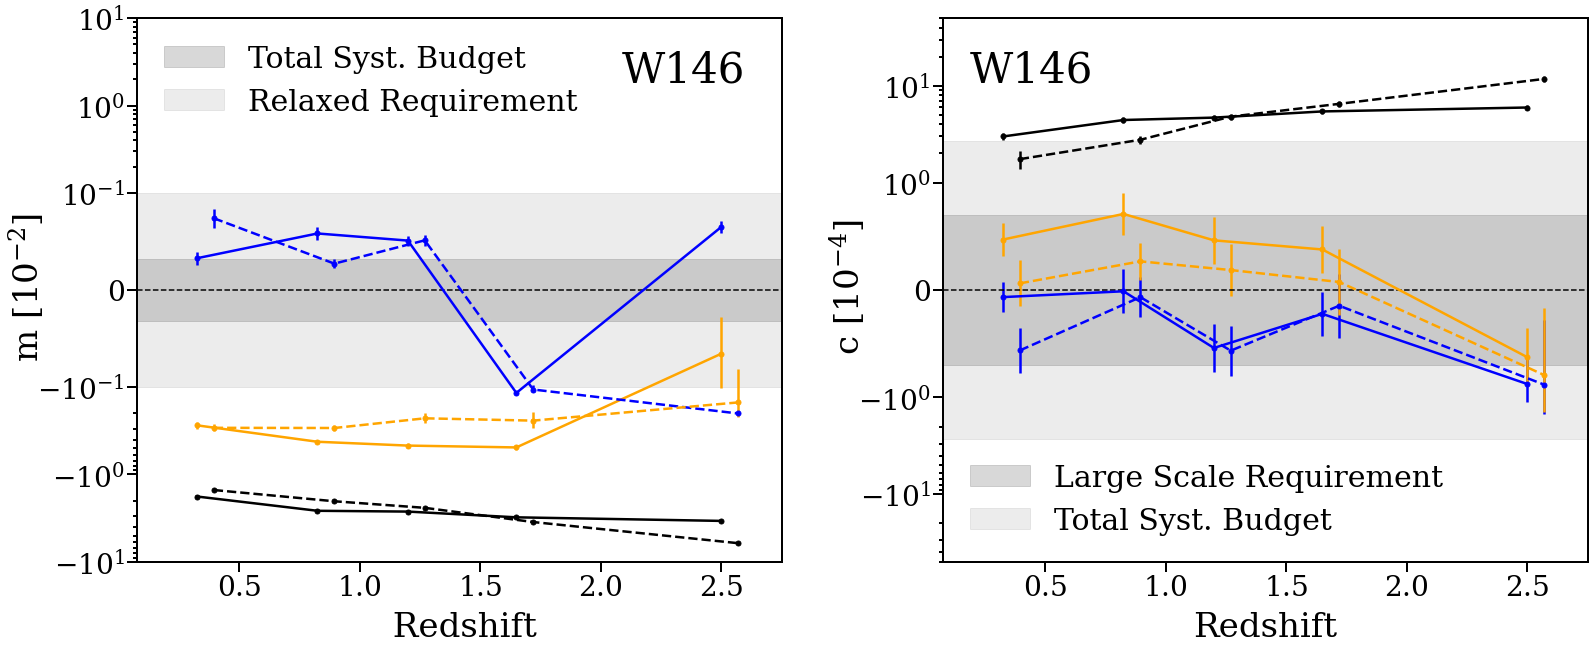

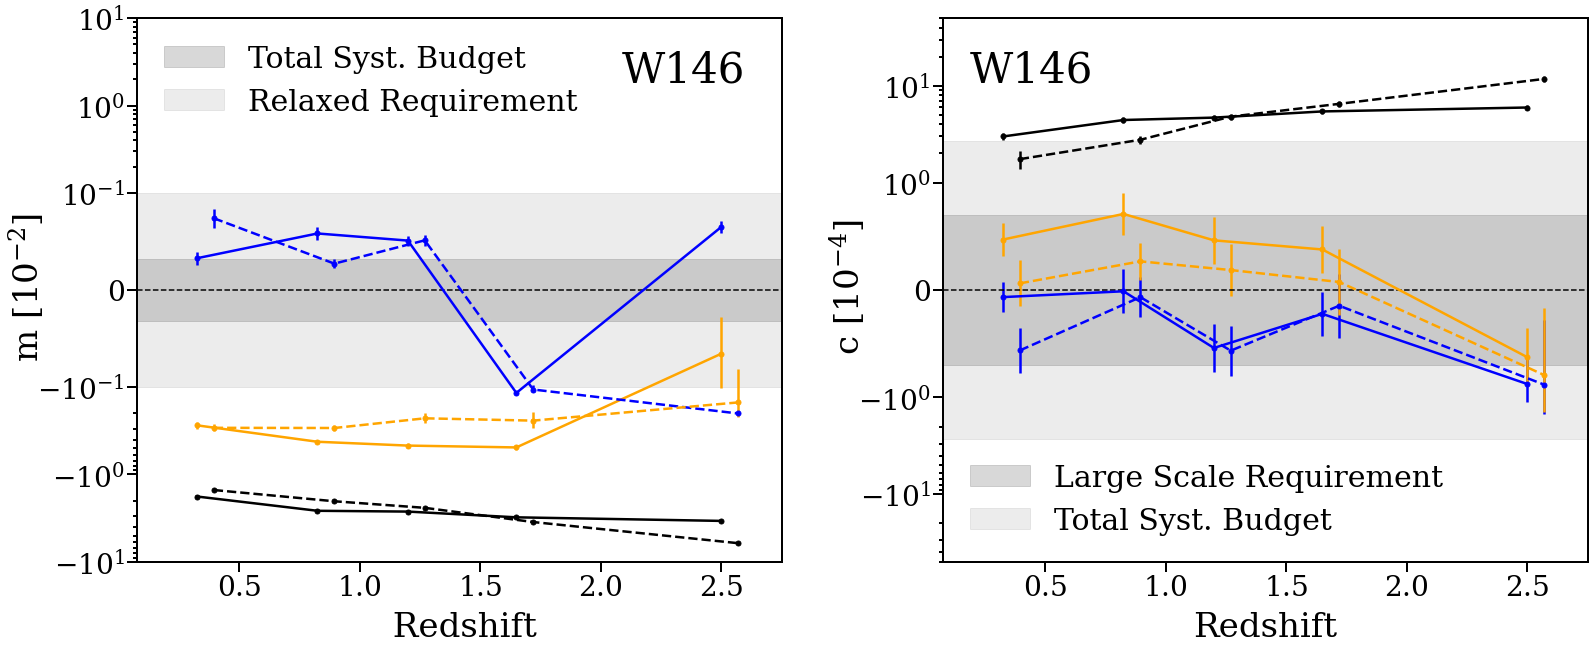

In [98]:
fig, axs = plt.subplots(figsize=(26,10), nrows=1, ncols=2, sharex=True, sharey=False)
fig.subplots_adjust(wspace=0.25, hspace=0.0)

fact = 1e2
fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1)
ylim=(-10, 10)
xlim=(0.2, 2.7)
yscale_linthresh=0.1
ylabel=r' m [$10^{-2}$] '




plot_subplot(
    ax=axs[0],
    y_values_dict={
        'm': star_bias['m_z'][:,-1],
        'corr': star_bias_corr['m_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr['m_z'][:,-1]
    },
    y_values_cd2_dict={
        'm': star_bias_cd2['m_z'][:,-1],
        'corr': star_bias_corr_cd2['m_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr_cd2['m_z'][:,-1]
    },
    y_values_err_dict={
        'm': star_bias['m_err_z'][:,-1],
        'corr': star_bias_corr['m_err_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr['m_err_z'][:,-1]
    },
    y_values_cd2_err_dict={
        'm': star_bias_cd2['m_err_z'][:,-1],
        'corr': star_bias_corr_cd2['m_err_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr_cd2['m_err_z'][:,-1]
    },
    x_vals = z_mid,
    title='',
    ylabel=r' m [$10^{-2}$] ',
    xlabel=r' Redshift',
    ylim=(-10, 10),
    yscale_linthresh=0.1,
    fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1),
    fill_between_xvals = [0,3],
    legend_labels=['', '', '', ''],
    legend = True, fill_legend = True, cd2_label = '',
    offset_cd2 = 0.07,
    xlim_offset = 0.25,
    colors = ['black', 'blue', 'orange'],
    legend_size = 30, label_fontsize = 34,
    tick_labelsize = 28, lw = 2.5
)

plot_subplot(
    ax=axs[1],
    y_values_dict={
        'm': star_bias['c_z'][:,-1],
        'corr': star_bias_corr['c_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr['c_z'][:,-1]
    },
    y_values_cd2_dict={
        'm': star_bias_cd2['c_z'][:,-1],
        'corr': star_bias_corr_cd2['c_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr_cd2['c_z'][:,-1]
    },
    y_values_err_dict={
        'm': star_bias['c_err_z'][:,-1],
        'corr': star_bias_corr['c_err_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr['c_err_z'][:,-1]
    },
    y_values_cd2_err_dict={
        'm': star_bias_cd2['c_err_z'][:,-1],
        'corr': star_bias_corr_cd2['c_err_z'][:,-1],
        'avgzcorr': star_bias_avgzcorr_cd2['c_err_z'][:,-1]
    },
    x_vals = z_mid,
    title='',
    ylabel=r' c [$10^{-4}$] ',
    xlabel=r'Redshift',
    ylim=(-50, 50),
    yscale_linthresh=1,
    fill_between_vals=(-0.7, 0.7,-2.7, 2.7),
    fill_between_xvals = [0,3],
    legend_labels=['', '', '', ''],
    legend = True, fill_legend = True,
    offset_cd2 = 0.07,
    xlim_offset = 0.25,
    fact = 1e4,
    colors = ['black', 'blue', 'orange'],
    legend_size = 30, label_fontsize = 34,
    tick_labelsize = 28,
    legend_loc = 'lower left', lw = 2.5
)
axs[0].text(2.6, 1.5*1e-0, 'W146', fontsize=42, verticalalignment='bottom', horizontalalignment='right')
axs[1].text(0.7, 9*1e0, 'W146', fontsize=42, verticalalignment='bottom', horizontalalignment='right')
#axs[0].text(3.3, 20.33*1e-0, 'W146', fontsize=47, verticalalignment='bottom', horizontalalignment='right')

save = True
if save:
    plt.savefig('PaperFigures/perf_corrbias_W.png', format='png', dpi=300,bbox_inches='tight')
    
plt.show()


## Analytical Prediction

In [16]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/Analyticpred_H/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_J = get_dict_shear(batches, dir_, add_ = 'J_')
dict_comb_F = get_dict_shear(batches, dir_, add_ = 'F_')
dict_comb_JF = get_dict_shear(batches, dir_, add_ = 'JF_')

In [17]:
star_bias_an_J = get_bias2(dict_comb_J, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)
star_bias_an_F = get_bias2(dict_comb_F, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)
star_bias_an_JF = get_bias2(dict_comb_JF, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2044
2087
2087
2103
2103
1913
1913
1853
1853
2044
2044
2087
2087
2103
2103
1913
1913
1853
1853
2044
2044
2087
2087
2103
2103
1913
1913
1853
1853


In [18]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/Analyticpred_H/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_J = get_dict_shear(batches, dir_, add_ = 'J_')
dict_comb_F = get_dict_shear(batches, dir_, add_ = 'F_')
dict_comb_JF = get_dict_shear(batches, dir_, add_ = 'JF_')

In [19]:
star_bias_an_J_cd2 = get_bias2(dict_comb_J, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)
star_bias_an_F_cd2 = get_bias2(dict_comb_F, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)
star_bias_an_JF_cd2 = get_bias2(dict_comb_JF, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462
2411
2411
1910
1910
1247
1247
1970
1970
2462
2462
2411
2411
1910
1910
1247
1247
1970
1970
2462
2462
2411
2411
1910
1910
1247
1247


In [20]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/SOMpred_H/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_SOM = get_dict_shear(batches, dir_, add_ = 'H158_')


In [21]:
star_bias_SOM = get_bias2(dict_comb_SOM, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044


/tmp/ipykernel_1149265/1712427547.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])


2044


/tmp/ipykernel_1149265/1712427547.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitShear, true_shear, obs_shear, p0 = [0, 0])


2087
2087
2103
2103
1913
1913
1853
1853


In [22]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/SOMpred_H/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_SOM = get_dict_shear(batches, dir_, add_ = 'H158_')

In [23]:
star_bias_SOM_cd2 = get_bias2(dict_comb_SOM, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462
2411
2411
1910
1910
1247
1247


In [24]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/Analyticpred_H_zbin/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_J = get_dict_shear(batches, dir_, add_ = 'J_')
dict_comb_F = get_dict_shear(batches, dir_, add_ = 'F_')
dict_comb_JF = get_dict_shear(batches, dir_, add_ = 'JF_')

In [25]:
star_bias_an_J_avg = get_bias2(dict_comb_J, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)
star_bias_an_F_avg = get_bias2(dict_comb_F, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)
star_bias_an_JF_avg = get_bias2(dict_comb_JF, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2044
2087
2087
2103
2103
1913
1913
1853
1853
2044
2044
2087
2087
2103
2103
1913
1913
1853
1853
2044
2044
2087
2087
2103
2103
1913
1913
1853
1853


In [26]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/Analyticpred_H_zbin/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_J = get_dict_shear(batches, dir_, add_ = 'J_')
dict_comb_F = get_dict_shear(batches, dir_, add_ = 'F_')
dict_comb_JF = get_dict_shear(batches, dir_, add_ = 'JF_')

In [27]:
star_bias_an_J_avg_cd2 = get_bias2(dict_comb_J, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)
star_bias_an_F_avg_cd2 = get_bias2(dict_comb_F, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)
star_bias_an_JF_avg_cd2 = get_bias2(dict_comb_JF, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462
2411
2411
1910
1910
1247
1247
1970
1970
2462
2462
2411
2411
1910
1910
1247
1247
1970
1970
2462
2462
2411
2411
1910
1910
1247
1247


In [28]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/SOMpred_H_zbin/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_SOM = get_dict_shear(batches, dir_, add_ = 'H158_')


In [29]:
star_bias_SOM_avg = get_bias2(dict_comb_SOM, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2044
2087
2087
2103
2103
1913
1913
1853
1853


In [30]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/SOMpred_H_zbin/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_SOM = get_dict_shear(batches, dir_, add_ = 'H158_')

In [31]:
star_bias_SOM_cd2_avg = get_bias2(dict_comb_SOM, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462
2411
2411
1910
1910
1247
1247


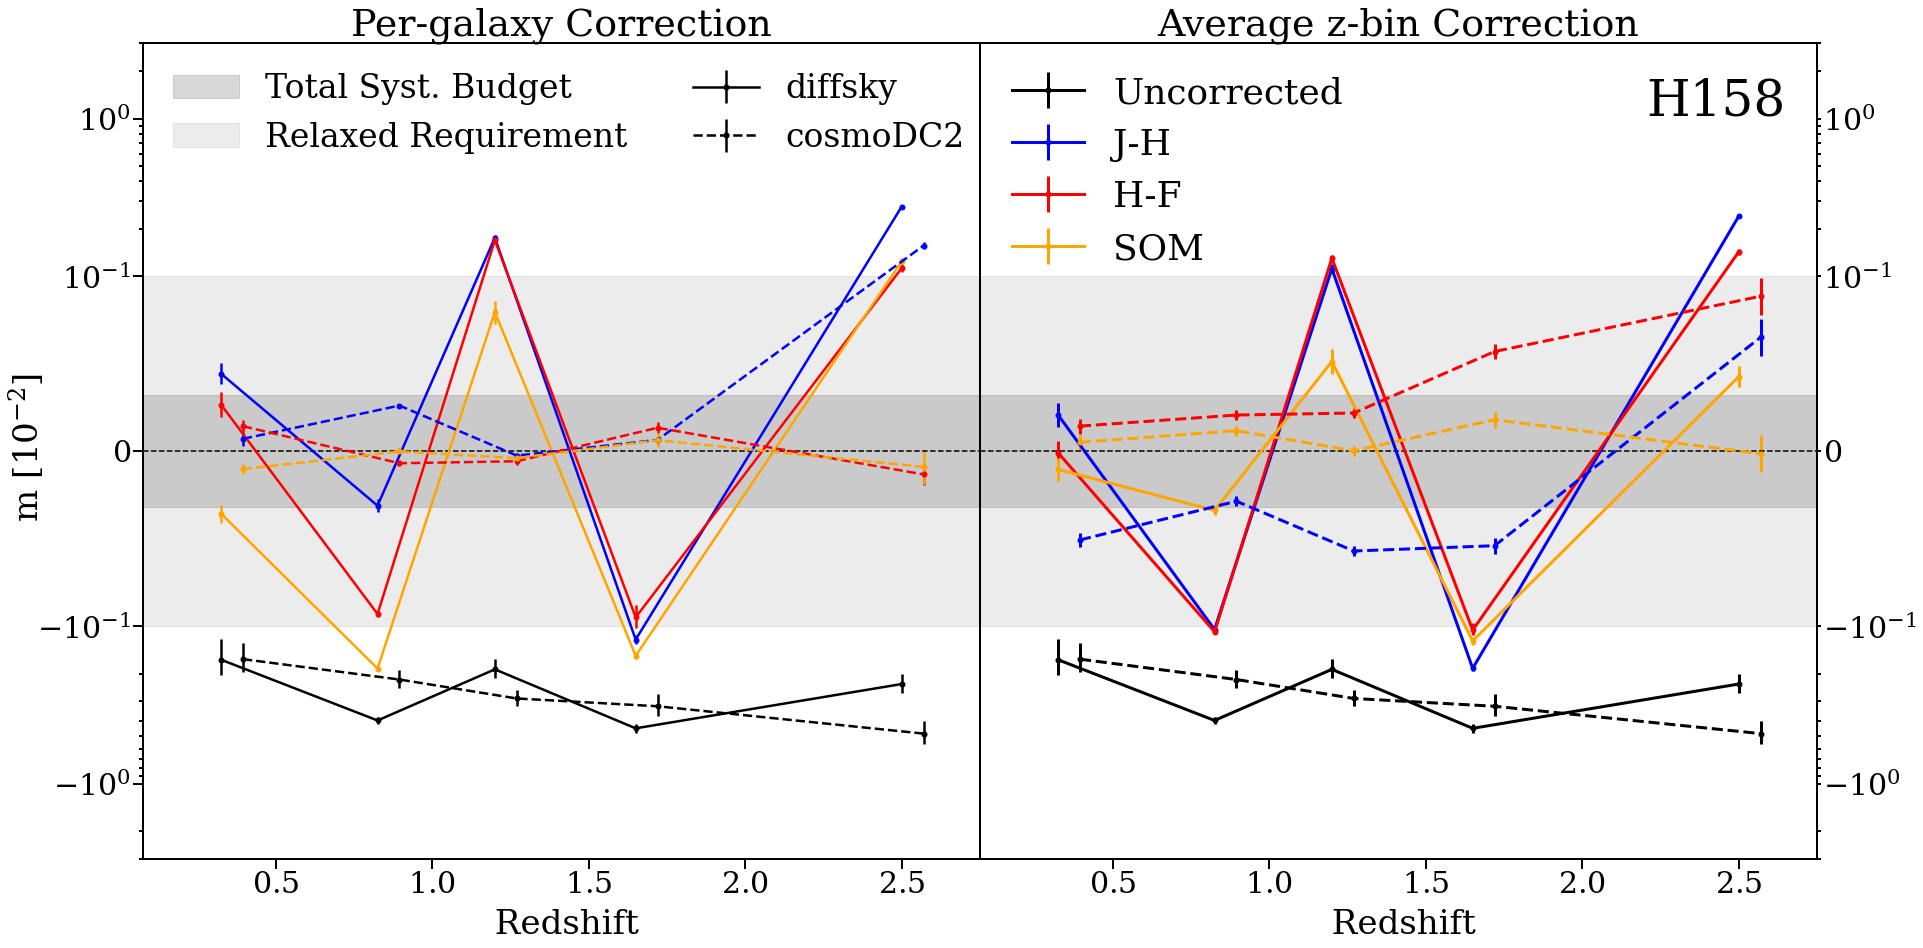

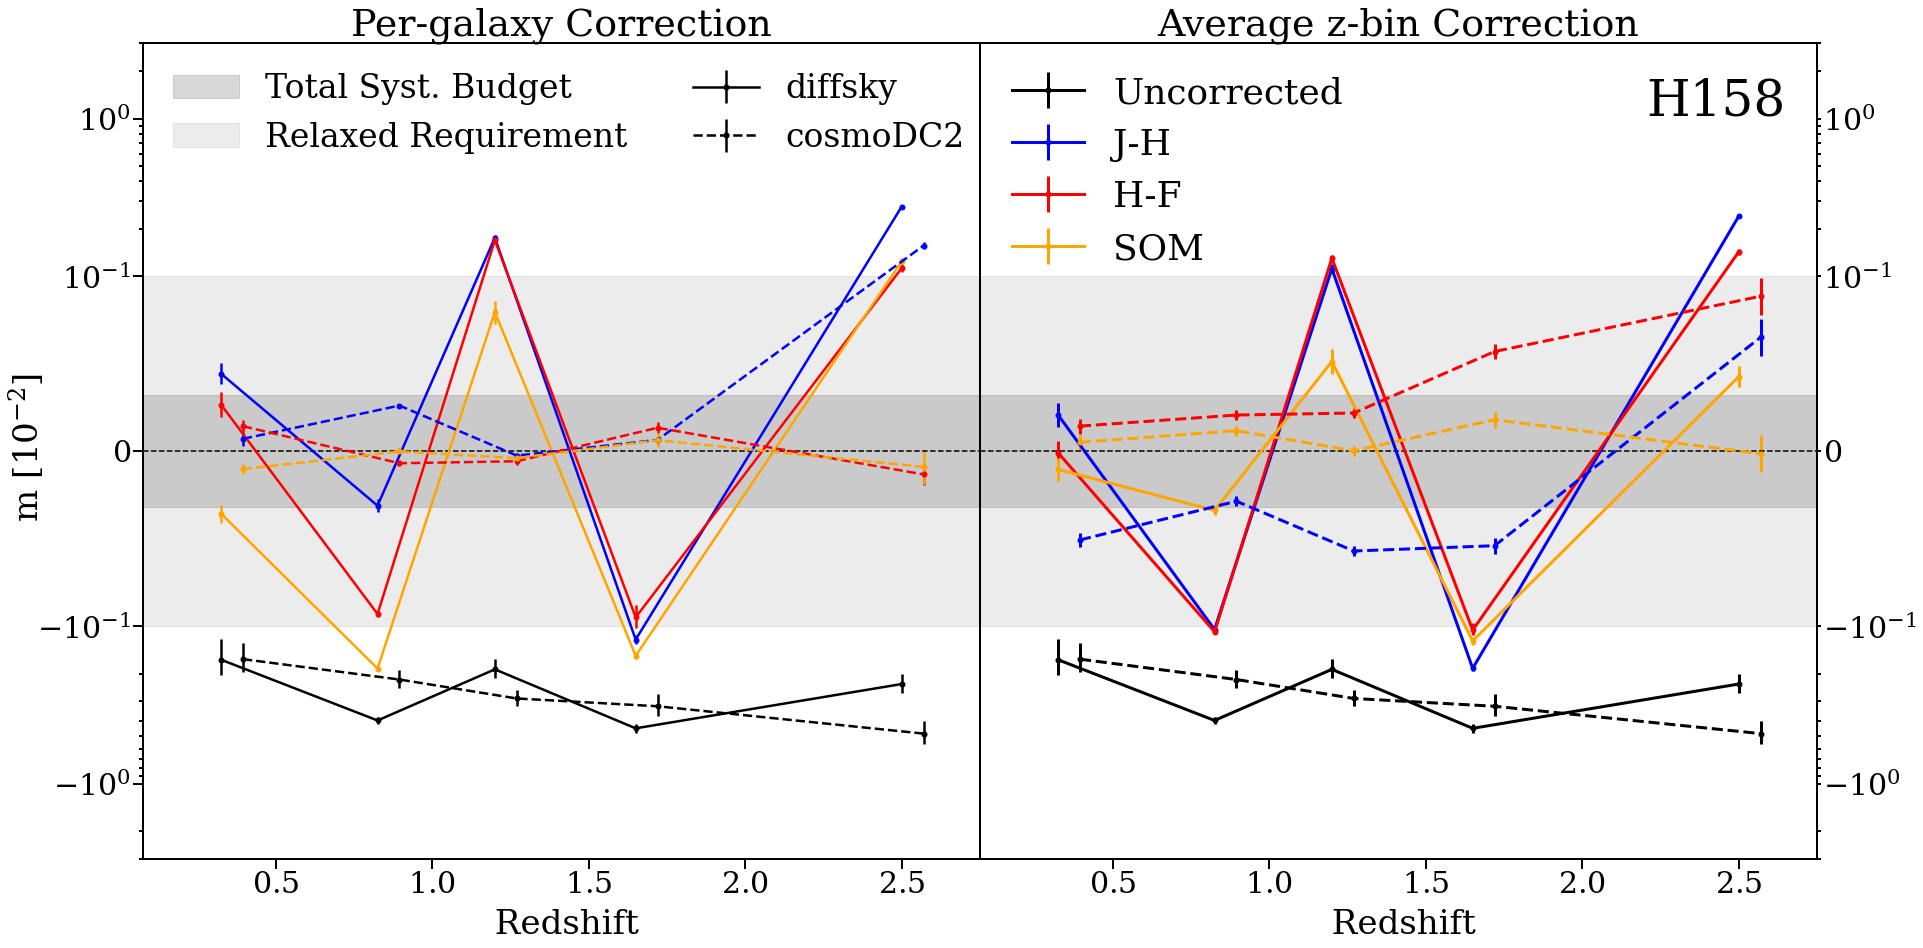

In [72]:
fig, axs = plt.subplots(figsize=(30,15), nrows=1, ncols=2, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

fact = 1e2
fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1)
ylim=(-10, 10)
xlim=(0.2, 2.7)
yscale_linthresh=0.1
ylabel=r' m [$10^{-2}$] '




plot_subplot(
    ax=axs[0],
    y_values_dict={
        'm': star_bias['m_z'][:,2],
        'corr': star_bias_an_J['m_z'][:,-1],
        'avgcorr': star_bias_an_F['m_z'][:,-1],
        'avgzcorr': star_bias_SOM['m_z'][:,-1]
    },
    y_values_cd2_dict={
        'm': star_bias_cd2['m_z'][:,2],
        'corr': star_bias_an_J_cd2['m_z'][:,-1],
        'avgcorr': star_bias_an_F_cd2['m_z'][:,-1],
        'avgzcorr': star_bias_SOM_cd2['m_z'][:,-1]
    },
    y_values_err_dict={
        'm': star_bias['m_err_z'][:,-1],
        'corr': star_bias_an_J['m_err_z'][:,-1],
        'avgcorr': star_bias_an_F['m_err_z'][:,-1],
        'avgzcorr': star_bias_SOM['m_err_z'][:,-1]
    },
    y_values_cd2_err_dict={
        'm': star_bias_cd2['m_err_z'][:,-1],
        'corr': star_bias_an_J_cd2['m_err_z'][:,-1],
        'avgcorr': star_bias_an_F_cd2['m_err_z'][:,-1],
        'avgzcorr': star_bias_SOM_cd2['m_err_z'][:,-1]
    },
    x_vals = z_mid,
    title='',
    ylabel=r' m [$10^{-2}$] ',
    xlabel=r' Redshift',
    ylim=(-3, 3),
    yscale_linthresh=0.1,
    fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1),
    fill_between_xvals = [0,3],
    legend_labels=['diffsky', '', '', ''],
    legend = True, fill_legend = True, cd2_label = 'cosmoDC2',
    offset_cd2 = 0.07,
    xlim_offset = 0.25,
    legend_size = 33, label_fontsize = 34,
    tick_labelsize = 30, lw = 2.5
)


axs[1].text(2.65, 9*1e-1, 'H158', fontsize=50, verticalalignment='bottom', horizontalalignment='right')
#axs[1].text(0.7, 9*1e0, 'W146', fontsize=47, verticalalignment='bottom', horizontalalignment='right')
#axs[0].text(3.3, 20.33*1e-0, 'W146', fontsize=47, verticalalignment='bottom', horizontalalignment='right')
axs[0].set_title('Per-galaxy Correction', fontsize = 38)



plot_subplot(
    ax=axs[1],
    y_values_dict={
        'm': star_bias['m_z'][:,2],
        'corr': star_bias_an_J_avg['m_z'][:,-1],
        'avgcorr': star_bias_an_F_avg['m_z'][:,-1],
        'avgzcorr': star_bias_SOM_avg['m_z'][:,-1]
    },
    y_values_cd2_dict={
        'm': star_bias_cd2['m_z'][:,2],
        'corr': star_bias_an_J_avg_cd2['m_z'][:,-1],
        'avgcorr': star_bias_an_F_avg_cd2['m_z'][:,-1],
        'avgzcorr': star_bias_SOM_cd2_avg['m_z'][:,-1]
    },
    y_values_err_dict={
        'm': star_bias['m_err_z'][:,-1],
        'corr': star_bias_an_J_avg['m_err_z'][:,-1],
        'avgcorr': star_bias_an_F_avg['m_err_z'][:,-1],
        'avgzcorr': star_bias_SOM_avg['m_err_z'][:,-1]
    },
    y_values_cd2_err_dict={
        'm': star_bias_cd2['m_err_z'][:,-1],
        'corr': star_bias_an_J_avg_cd2['m_err_z'][:,-1],
        'avgcorr': star_bias_an_F_avg_cd2['m_err_z'][:,-1],
        'avgzcorr': star_bias_SOM_cd2_avg['m_err_z'][:,-1]
    },
    x_vals = z_mid,
    title='',
    ylabel=r'',
    xlabel=r' Redshift',
    ylim=(-3, 3),
    yscale_linthresh=0.1,
    fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1),
    fill_between_xvals = [0,3],
    legend_labels=['Uncorrected', 'J-H', 'H-F', 'SOM'],
    legend = True, fill_legend = False, cd2_label = '',
    offset_cd2 = 0.07,
    xlim_offset = 0.25,
    legend_size = 36, label_fontsize = 34,
    tick_labelsize = 30,right_ticks=True, ncol = 1, lw = 3
)

axs[1].set_title('Average z-bin Correction', fontsize = 38)

save = False
if save:
    plt.savefig('PaperFigures/Realcorrection.png', format='png', dpi=300,bbox_inches='tight')
    
plt.show()

## Impact of SEDs

In [45]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_diffsky/SOMpred_H/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_SOM = get_dict_shear(batches, dir_, add_ = 'H158_cd2train_')


In [46]:
star_bias_SOM = get_bias2(dict_comb_SOM, z_binning = True, z = z_diffsky,start_idx =0, end_idx = 10000)

2044
2044
2087
2087
2103
2103
1913
1913
1853
1853


In [47]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/SOMpred_H/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_SOM = get_dict_shear(batches, dir_, add_ = 'H158_25pSEDCut_')

In [48]:
star_bias_SOM_cd2_25 = get_bias2(dict_comb_SOM, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462
2411
2411
1910
1910
1247
1247


In [49]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
g_list = ['g1_0', 'g1_02', 'g1_n02']
dir_ = "shear_measurement_cosmoDC2_final/SOMpred_H/"
#dir_ = "shear_measurement/TrueAvgCorrPSF/"
dict_comb_SOM = get_dict_shear(batches, dir_, add_ = 'H158_55pSEDCut_')

In [50]:
star_bias_SOM_cd2_55 = get_bias2(dict_comb_SOM, z_binning = True, z = z_cd2,start_idx =0, end_idx = 10000)

1970
1970
2462
2462
2411
2411
1910
1910
1247
1247


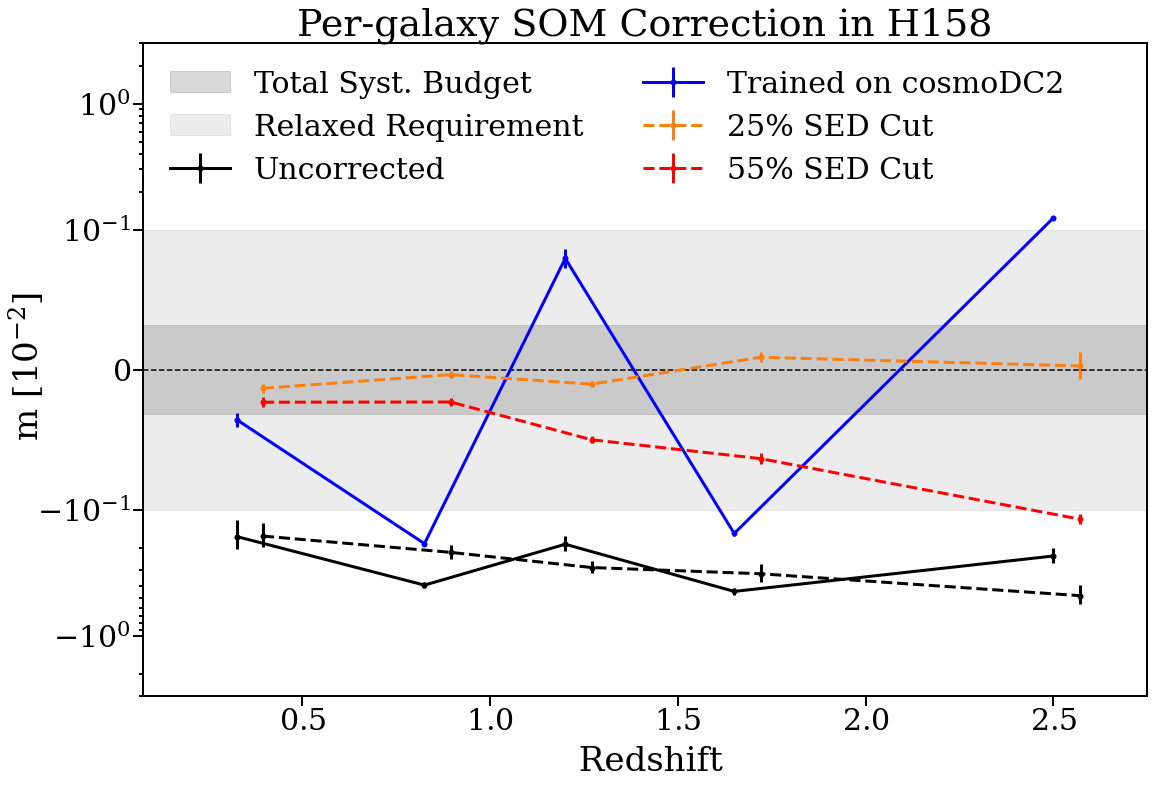

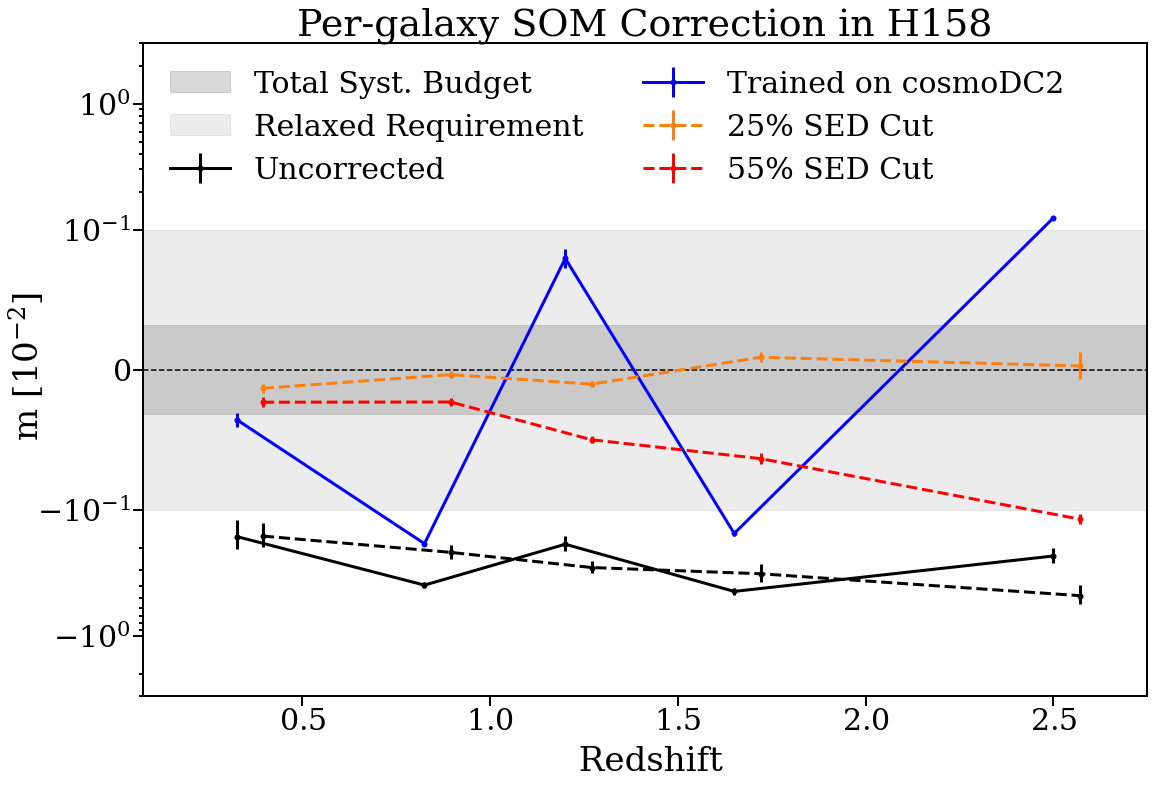

In [61]:
fig, axs = plt.subplots(figsize=(18,12), nrows=1, ncols=1, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

fact = 1e2
fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1)
ylim=(-10, 10)
xlim=(0.2, 2.7)
yscale_linthresh=0.1
ylabel=r' m [$10^{-2}$] '


axs = [axs]

plot_subplot(
    ax=axs[0],
    y_values_dict={
        'm': star_bias['m_z'][:,2],
        'corr': star_bias_SOM['m_z'][:,-1]
    },
    y_values_cd2_dict={
        'm': star_bias_cd2['m_z'][:,2],
        'avgcorr': star_bias_SOM_cd2_25['m_z'][:,-1],
        'avgzcorr': star_bias_SOM_cd2_55['m_z'][:,-1]
    },
    y_values_err_dict={
        'm': star_bias['m_err_z'][:,-1],
        'corr': star_bias_SOM['m_err_z'][:,-1]
    },
    y_values_cd2_err_dict={
        'm': star_bias_cd2['m_err_z'][:,-1],
        'avgcorr': star_bias_SOM_cd2_25['m_err_z'][:,-1],
        'avgzcorr': star_bias_SOM_cd2_55['m_err_z'][:,-1]
    },
    x_vals = z_mid,
    title='',
    ylabel=r' m [$10^{-2}$] ',
    xlabel=r' Redshift',
    ylim=(-3, 3),
    yscale_linthresh=0.1,
    fill_between_vals=(-3.2e-2, 3.2e-2, -0.1, 0.1),
    fill_between_xvals = [0,3],
    legend_labels=['Uncorrected', 'Trained on cosmoDC2', '25% SED Cut', '55% SED Cut'],
    legend_labels_cd2=['Uncorrected', '25% SED Cut', '55% SED Cut'],
    legend = True, fill_legend = True,
    offset_cd2 = 0.07,
    xlim_offset = 0.25,
    legend_size = 30, label_fontsize = 34,
    tick_labelsize = 30, colors_cd2 = ['black', 'C1', 'red'],
    lw = 3
)


#axs[0].text(2.7, 9*1e-1, 'H158', fontsize=55, verticalalignment='bottom', horizontalalignment='right')
#axs[1].text(0.7, 9*1e0, 'W146', fontsize=47, verticalalignment='bottom', horizontalalignment='right')
#axs[0].text(3.3, 20.33*1e-0, 'W146', fontsize=47, verticalalignment='bottom', horizontalalignment='right')
axs[0].set_title('Per-galaxy SOM Correction in H158', fontsize = 38)

save = True
if save:
    plt.savefig('PaperFigures/Real_SOMcorrSEDImpact.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Basis plot

In [78]:
def read_fits(filename):
    images = []
    with fits.open(filename + '.fits') as hdul:
        primary_image = hdul[0].data
        #print("Primary image shape:", primary_image.shape)
        images.append(primary_image)
        # Access the subsequent HDUs (additional images)
        for i in range(1, len(hdul)):
            image = hdul[i].data
            images.append(image)
    return np.array(images)

def get_data(root_dir, shear_str = '0', batch = '0_999', return_psf = True,return_gal = True, filters = None):
   
    avg_true_psf, avg_star_psf = {}, {}
    gal_stamps = {}
    if filters is None:
        filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
    for filter_name in filters:
        gal_file_name = root_dir + filter_name + '/g1' + shear_str + '_g20/galStamps_' + batch 
        star_psf_file_name = root_dir + filter_name + '/StarPSF/' + 'PSF_' + batch 
        true_psf_file_name = root_dir + filter_name + '/TruePSF/' + 'PSF_' + batch
        if return_psf:
            avg_true_psf[filter_name] = read_fits(true_psf_file_name)
            avg_star_psf[filter_name] = read_fits(star_psf_file_name)
        if return_gal:
            gal_stamps[filter_name] = read_fits(gal_file_name)

    return gal_stamps, avg_true_psf, avg_star_psf


In [79]:
#SCAs, x_pos, y_pos, z_sims = get_pos()

In [80]:
#len(z_sims)

In [81]:
root_dir = 'sim_images/10000Gal_NoNoise_diffsky/'
gal_stamps_0, avg_true_psf_0, avg_star_psf_0 = get_data(root_dir,shear_str = '0')

In [82]:
def radial_profile(image, nbins = None, offset = 0):
    # Calculate the center of the image
    center =  np.array(image.shape) // 2.0#- 0.5 #+ 0.5*roman.pixel_scale/4 + offset
    #center = np.array(np.unravel_index(image.argmax(), image.shape))
    #print(center)

    # Create a grid of coordinates
    y, x = np.indices(image.shape, dtype = np.float64)
    #y[y> center[0]] += 0.5
    #y[y< center[0]] += 0.5
    
    #x[x> center[1]] += 0.5
    #x[x< center[1]] += 0.5
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)

    # Get unique radii and calculate average intensity for each radius
    radii = np.unique(r)
    if nbins is None:
        intensity = np.zeros(len(radii))
        intensity[radii < 35] = np.array([np.mean(image[r == radius]) for radius in radii[radii < 35]])

        return radii, intensity
    
    center = np.array(image.shape) // 2 - 0.5 #+ 0.5*roman.pixel_scale/4
    #center = np.array(np.unravel_index(image.argmax(), image.shape))

    # Create a grid of coordinates
    y, x = np.indices(image.shape)
    theta = np.arctan2((y - center[0]), (x - center[1]))
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)

    radii = np.unique(r)
    # Use logspace to create logarithmically spaced radial bins
    #bins = np.logspace(0.005, center[0]/2, num=nbins)
    bins = np.logspace(0.5, center[0]/2/2, num=int(3/4*nbins))
    bins2 = np.linspace(center[0]/2/2, center[0]/2, num=int(1/4*nbins))
    bins = np.hstack([bins, bins2])
    bins = np.unique(bins)
    
    # Use np.histogram to calculate the radial profile
    radial_sum_r, _ = np.histogram(r, bins=bins, weights=image*np.cos(2*theta*0))
    radial_count, _ = np.histogram(r, bins=bins)

    # Avoid division by zero
    radial_profile_r = radial_sum_r/ radial_count
    radial_profile_r[radial_count == 0] = 0#np.divide(radial_sum_r, radial_count, where=radial_count != 0)
    
    bins = (bins[:-1] + bins[1:]) / 2

    return bins, radial_profile_r

In [83]:
def read_basis(file_name):
    pickle_in = open(file_name,"rb")
    arr = pickle.load(pickle_in)
    return arr[0], arr[1], arr[2], arr[3]

In [84]:
def effective_wavelength(bandpass, order = 2, norm = False, cent = 1):
    wave_arr = np.linspace(bandpass.blue_limit, bandpass.red_limit, 1000)
    transmission = bandpass(wave_arr)
    numerator = np.trapz((wave_arr - cent*bandpass.effective_wavelength)**order * transmission, wave_arr)
    denominator = np.trapz(transmission, wave_arr)
    lambda_eff = numerator
    if norm:
        lambda_eff = numerator / denominator
    return lambda_eff

In [85]:
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
pickle_in = open("SED_fit_coeff/final_run/10000Gal_1ordfit_A_YJHFW_diffsky_10307", "rb")
coeffs = pickle.load(pickle_in)
pickle_in.close()
coeff_diff = {}
coeff_gal = {}
coeff_star = {}
flux_star = {}
flux_gal = {}
coeff_diff_0th = {}
coeff_diff_2nd = {}
coeff_diff_3rd = {}
for filter_ in use_filters:
    coeffs_gal_slope = coeffs['gal'][1][filter_]
    coeffs_star_slope = coeffs['star:'][1][filter_]
    coeff_diff[filter_] = coeffs_star_slope - coeffs_gal_slope
    coeff_gal[filter_] = coeffs['gal'][1][filter_]
    coeff_star[filter_] = coeffs['star:'][1][filter_]
    flux_star[filter_] = coeffs['star_fluxes'][filter_]
    flux_gal[filter_] = coeffs['gal_fluxes'][filter_]
    norm_fact = coeffs['gal_fluxes'][filter_]*coeffs['star_fluxes'][filter_]
    coeff_diff_0th[filter_] = coeffs['star:'][0][filter_]- coeffs['gal'][0][filter_]
    coeff_diff_2nd[filter_] = coeffs['star:'][2][filter_]*coeffs['gal'][0][filter_] - coeffs['star:'][0][filter_]*coeffs['gal'][2][filter_]
    coeff_diff_2nd[filter_] = coeff_diff_2nd[filter_]#/norm_fact

In [87]:
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
pickle_in = open("SED_fit_coeff/final_run/10000Gal_A_YJHFW_diffsky_10307", "rb")
coeffs = pickle.load(pickle_in)
pickle_in.close()
coeff_diff_ = {}
coeff_gal = {}
coeff_star = {}
flux_star = {}
flux_gal = {}
coeff_diff_2nd_ = {}
coeff_diff_3rd_ = {}
for filter_ in use_filters:
    coeffs_gal_slope = coeffs['gal'][1][filter_]
    coeffs_star_slope = coeffs['star:'][1][filter_]
    coeff_diff_[filter_] = coeffs_star_slope - coeffs_gal_slope
    coeff_gal[filter_] = coeffs['gal'][1][filter_]
    coeff_star[filter_] = coeffs['star:'][1][filter_]
    flux_star[filter_] = coeffs['star_fluxes'][filter_]
    flux_gal[filter_] = coeffs['gal_fluxes'][filter_]
    norm_fact = coeffs['gal_fluxes'][filter_]*coeffs['star_fluxes'][filter_]
    #coeff_diff_2nd_[filter_] = coeffs['star:'][2][filter_][:,0]*coeffs['gal'][0][filter_] - coeffs['star:'][0][filter_]*coeffs['gal'][2][filter_][:,0]
    coeff_diff_2nd_[filter_] = coeffs['star:'][2][filter_]*coeffs['gal'][0][filter_] - coeffs['star:'][0][filter_]*coeffs['gal'][2][filter_]
    coeff_diff_2nd_[filter_] = coeff_diff_2nd_[filter_]#/norm_fact
    #coeff_diff_3rd[filter_] = coeffs['star:'][2][filter_][:,1] - coeffs['gal'][2][filter_][:,1]

In [88]:
imgs_basis0,rad_prof_basis0, rad_prof2_r_basis0, rad_prof2_im_basis0 = read_basis("Image_Basis/Basis_0")
imgs_basis,rad_prof_basis, rad_prof2_r_basis, rad_prof2_im_basis = read_basis("Image_Basis/Basis_1")
imgs_basis2,rad_prof_basis2, rad_prof2_r_basis2, rad_prof2_im_basis2 = read_basis("Image_Basis/Basis_2")
imgs_basis3,rad_prof_basis3, rad_prof2_r_basis3, rad_prof2_im_basis3 = read_basis("Image_Basis/Basis_3")

In [89]:
imgs_basis_02 = {}
norm0  = {}
norm2 = {}
for filter_name in use_filters:
    norm2[filter_name] = effective_wavelength(roman_filters[filter_name])
    norm0[filter_name] = effective_wavelength(roman_filters[filter_name], order = 0)
    norm3 = effective_wavelength(roman_filters[filter_name], order = 3)
    imgs_basis_02[filter_name] =(norm0[filter_name]*imgs_basis2[filter_name][6] - norm2[filter_name]*imgs_basis0[filter_name][6])

In [90]:
diff_psf = {}
corr_diff_psf = {}
corr_diff2nd_psf = {}
for filter_name in use_filters:
    diff_img = np.zeros(avg_star_psf_0[filter_name][0].shape)
    corr_diff_img = np.zeros(avg_star_psf_0[filter_name][0].shape)
    corr_diff2nd_img = np.zeros(avg_star_psf_0[filter_name][0].shape)
    num_ = len(avg_star_psf_0[filter_name])
    for i in range(num_):
        star_img_test =avg_star_psf_0[filter_name][i].copy()
        star_img_test/= np.sum(star_img_test)
        
        gal_img_test =avg_true_psf_0[filter_name][i].copy()
        gal_img_test/= np.sum(gal_img_test)
        #corr_img = star_img_test - imgs_basis['H158'][0]*coeff_all['H158'][0]
        
        #if filter_name == 'Z087':
        #    corr_img = star_img_test
        #else:
        corr_diff_img += imgs_basis[filter_name][SCAs[i] - 1]*coeff_diff[filter_name][i]
        corr_diff2nd_img += (norm0[filter_name]*imgs_basis2[filter_name][SCAs[i] - 1] - norm2[filter_name]*imgs_basis0[filter_name][SCAs[i] - 1])*coeff_diff_2nd_[filter_name][i]
        #corr_diff2nd_img += (imgs_basis0[filter_name][SCAs[i] - 1])*coeff_diff_0th[filter_name][i]
        corr_diff2nd_img -= (imgs_basis[filter_name][SCAs[i] - 1])*(coeff_diff[filter_name][i] - coeff_diff_[filter_name][i])
        #corr_diff2nd_img += imgs_basis3[filter_name][SCAs[i] - 1]*coeff_diff_3rd[filter_name][i]
        diff_img += star_img_test - gal_img_test
        #corr_img = star_img_test - imgs_basis[filter_name][SCAs[i] - 1]*coeff_all[filter_name][i] - imgs_basis_2[filter_name][SCAs[i] - 1]*coeff2_all[filter_name][i]
        #corr_img = star_img_test - imgs_basis[filter_name][SCAs[i] - 1]*mean_filt
    diff_psf[filter_name] = diff_img/num_
    corr_diff_psf[filter_name] = corr_diff_img/num_
    corr_diff2nd_psf[filter_name] = corr_diff2nd_img/num_

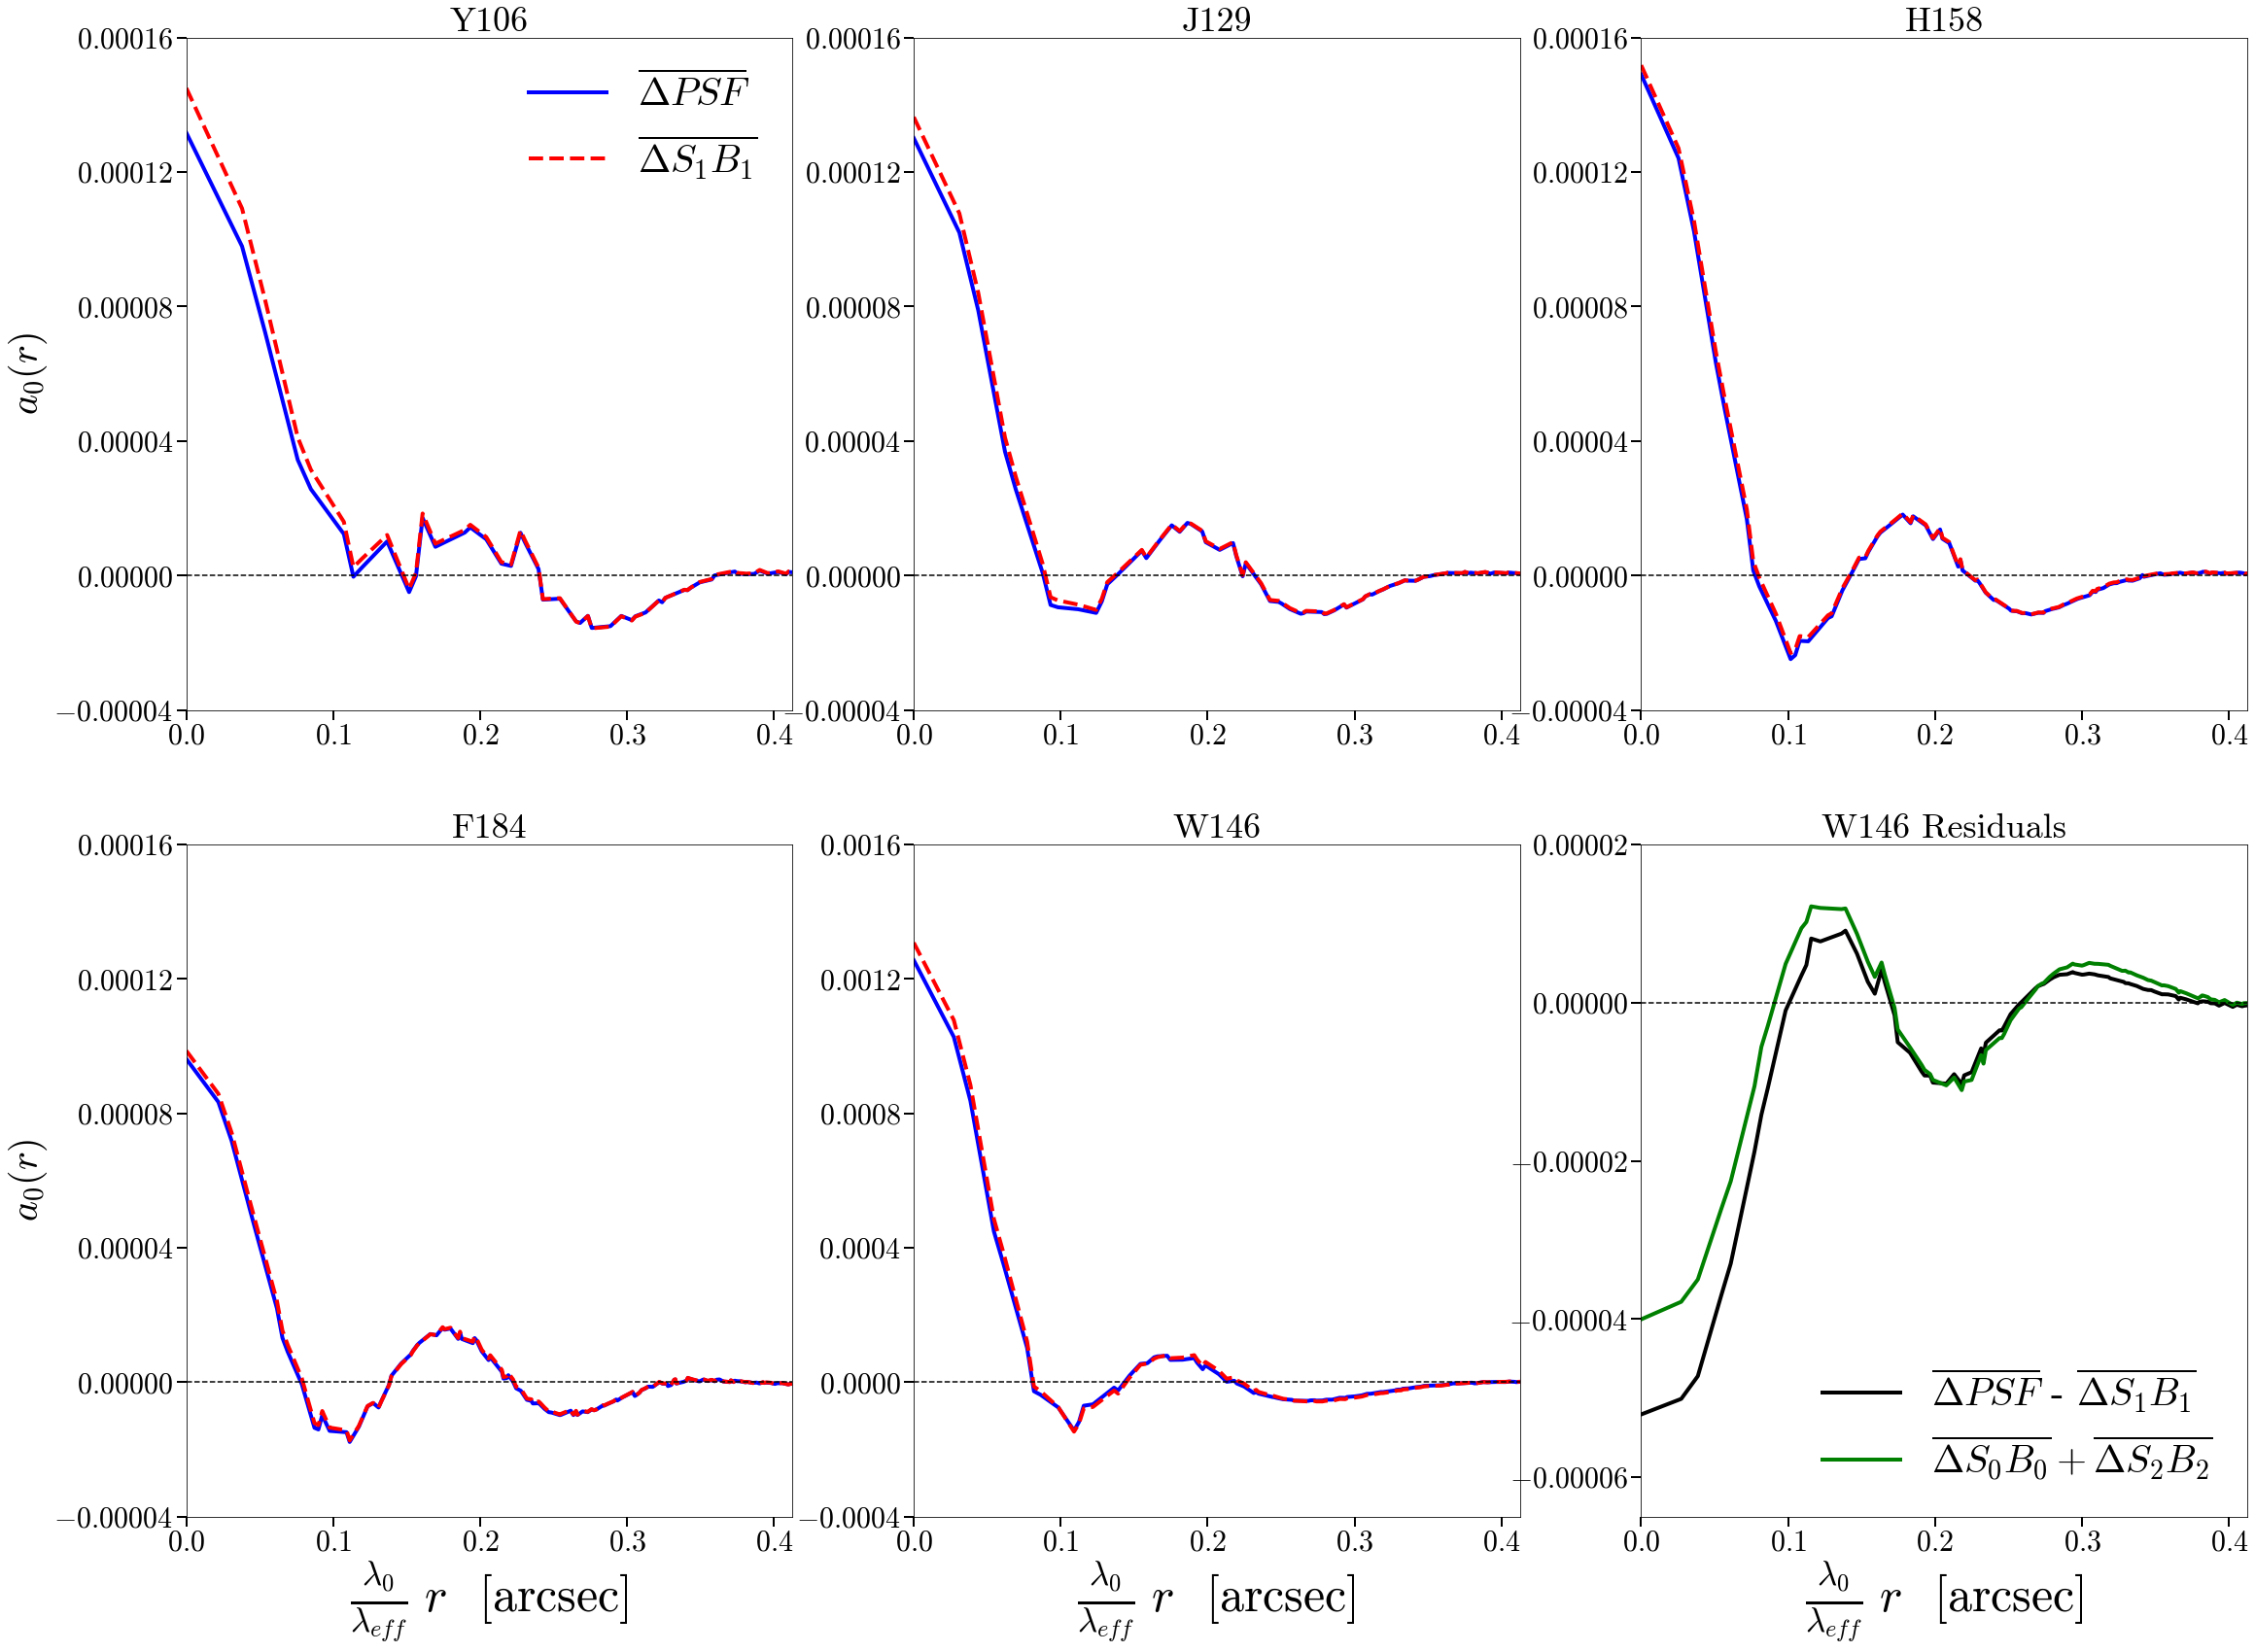

In [261]:
fig, axs = plt.subplots(figsize=(38,28), nrows=2, ncols=3, sharex=False, sharey=False)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
colors = ['blue', 'orange', 'green']
#x_labels = [r'z-y',r'y-j',r'j-h',r'h-f',r'f-w', r'z-y$_s$', r'y - j$_s$',r'j-h$_s$',r'h-f$_s$',r'f-w$_s$','x', 'y', 'SCA']
#x_labels =[]
labels = ['PC 1', 'PC 2', 'PC 3']
SCA = 7
scale = roman.pixel_scale/4
lam_ratio = 1460/eff_wave
for i in range(2):
    max_ = 2
    if i == 0:
        max_ = 3
    for j in range(max_):
        filter_name = str(filters[3*i + j ])#.copy()
        l = j
        if filter_name == 'K213':
            filter_name = 'W146'
            l += 1
        #a_0 = np.array(rad_profs_all[3*i + l +1 ])[SCAs[:1000] == SCA]
        #mean_a0 = np.mean(a_0, axis = 0)
        #std_a0 = np.std(a_0, axis = 0)/np.sqrt(len(a_0) - 1)
        img_bas = imgs_basis[filter_name][SCA - 1]
        rad_prof_r, mean_a0 = radial_profile(diff_psf[filter_name])
        #rad_prof_r, rad_prof = radial_profile(img_bas)
        rad_prof_r, rad_prof = radial_profile(corr_diff_psf[filter_name])
        rad_prof_r, rad_prof_2nd = radial_profile(corr_diff2nd_psf[filter_name])
        #img_bas_2 = imgs_basis_2[filter_name][SCA - 1]
        #rad_prof_r_2, rad_prof_2 = radial_profile(img_bas)
        #rad_prof *= np.mean(coeff_diff[filter_name][:1000])
        int_str = r'$\int \;  d\lambda \; PSF(x,y, \lambda) F(\lambda) (\lambda - \lambda_0)$'
        int_str = r'$\overline{\Delta S_1 B_1}$'
        #axs[i,j].plot(prof_t_1[0], prof_t_1[1]/np.min(prof_t_1[1]), lw = 4,color = 'red', label = int_str)
        axs[i,j].plot(r_bin_0*scale*lam_ratio[3*i + l ], mean_a0, lw = 4,color = colors[0], label = r'$\overline{\Delta PSF}$')
        axs[i,j].plot(r_bin_0*scale*lam_ratio[3*i + l ], rad_prof[:len(r_bin_0)], lw = 4,ls = '--', color = 'red', label = int_str)
        
        axs[i,j].set_title( filters[3*i + l] , fontsize = 36)
        axs[i,j].set_xlim(0,15*scale)
        #axs[i,j].set_ylim(-0.3,1)
        #axs[i,j].set_xscale('symlog')
        axs[i,j].axhline(y = 0, color = 'black', ls = '--')
        axs[i,j].tick_params(axis='both', which='major', labelsize=22)
        axs[i,j].tick_params('both', length=10, width=2, labelsize=30, which='major')
        axs[i,j].tick_params('both', length=10, width=2, labelsize=30, which='minor')
        axs[i,j].yaxis.set_major_locator(plt.MaxNLocator(5))

axs[0,0].set_ylabel(r'$a_0 (r)$', fontsize = 40)
axs[1,0].set_ylabel(r'$a_0 (r)$', fontsize = 40)
axs[1,0].set_xlabel(r'$\frac{\lambda_0}{\lambda_{eff}}\; r $  [arcsec]', fontsize = 50)
axs[1,1].set_xlabel(r'$\frac{\lambda_0}{\lambda_{eff}}\; r $  [arcsec]', fontsize = 50)
axs[1,2].set_xlabel(r'$\frac{\lambda_0}{\lambda_{eff}}\; r $  [arcsec]', fontsize = 50)
axs[0,0].legend(frameon = False, fontsize = 40)


i, j = 1,2
rad_prof02_r, rad_prof02 = radial_profile(imgs_basis_02)
#rad_basis_02 = rad_prof02[:len(r_bin_0)]*np.mean(coeff_diff_2nd[filter_name][:1000])
rad_basis_02 = rad_prof_2nd#*0
diff = mean_a0 - rad_prof[:len(r_bin_0)]
int_str2 = r'$\overline{\Delta S_0 B_0} + \overline{\Delta S_2 B_2}$'
axs[1,2].plot(r_bin_0*scale*lam_ratio[3*i + l ], diff, lw = 4,color = 'black', label = r'$\overline{\Delta PSF}$ - ' + int_str)
axs[1,2].plot(r_bin_0*scale*lam_ratio[3*i + l ], rad_basis_02, lw = 4,color = 'green', label = int_str2)
axs[1,2].legend(loc = 'lower right',frameon = False, fontsize = 40)
#axs[2,2].plot(r_bin_0*scale*lam_ratio[3*i + l ], rad_prof[:len(r_bin_0)], lw = 4,ls = '--', color = 'red', label = int_str)
axs[i,j].set_title( 'W146 Residuals', fontsize = 36)
axs[i,j].set_xlim(0,15*scale)
#axs[i,j].set_ylim(-0.3,1)
#axs[i,j].set_xscale('symlog')
axs[i,j].axhline(y = 0, color = 'black', ls = '--')
axs[i,j].tick_params(axis='both', which='major', labelsize=22)
axs[i,j].tick_params('both', length=10, width=2, labelsize=30, which='major')
axs[i,j].tick_params('both', length=10, width=2, labelsize=30, which='minor')
axs[i,j].yaxis.set_major_locator(plt.MaxNLocator(5))
axs[i,j].ticklabel_format(axis='y', style='plain')
axs[1,0].ticklabel_format(axis='y', style='plain')

axs[0,0].set_ylim(-4e-5,1.6e-4 )
axs[0,1].set_ylim(-4e-5,1.6e-4 )
axs[0,2].set_ylim(-4e-5,1.6e-4 )
axs[1,0].set_ylim(-4e-5,1.6e-4  )
axs[1,1].set_ylim(-4e-4,1.6e-3 )
axs[1,2].set_ylim(-6.5e-5,2e-5 )

plt.show()

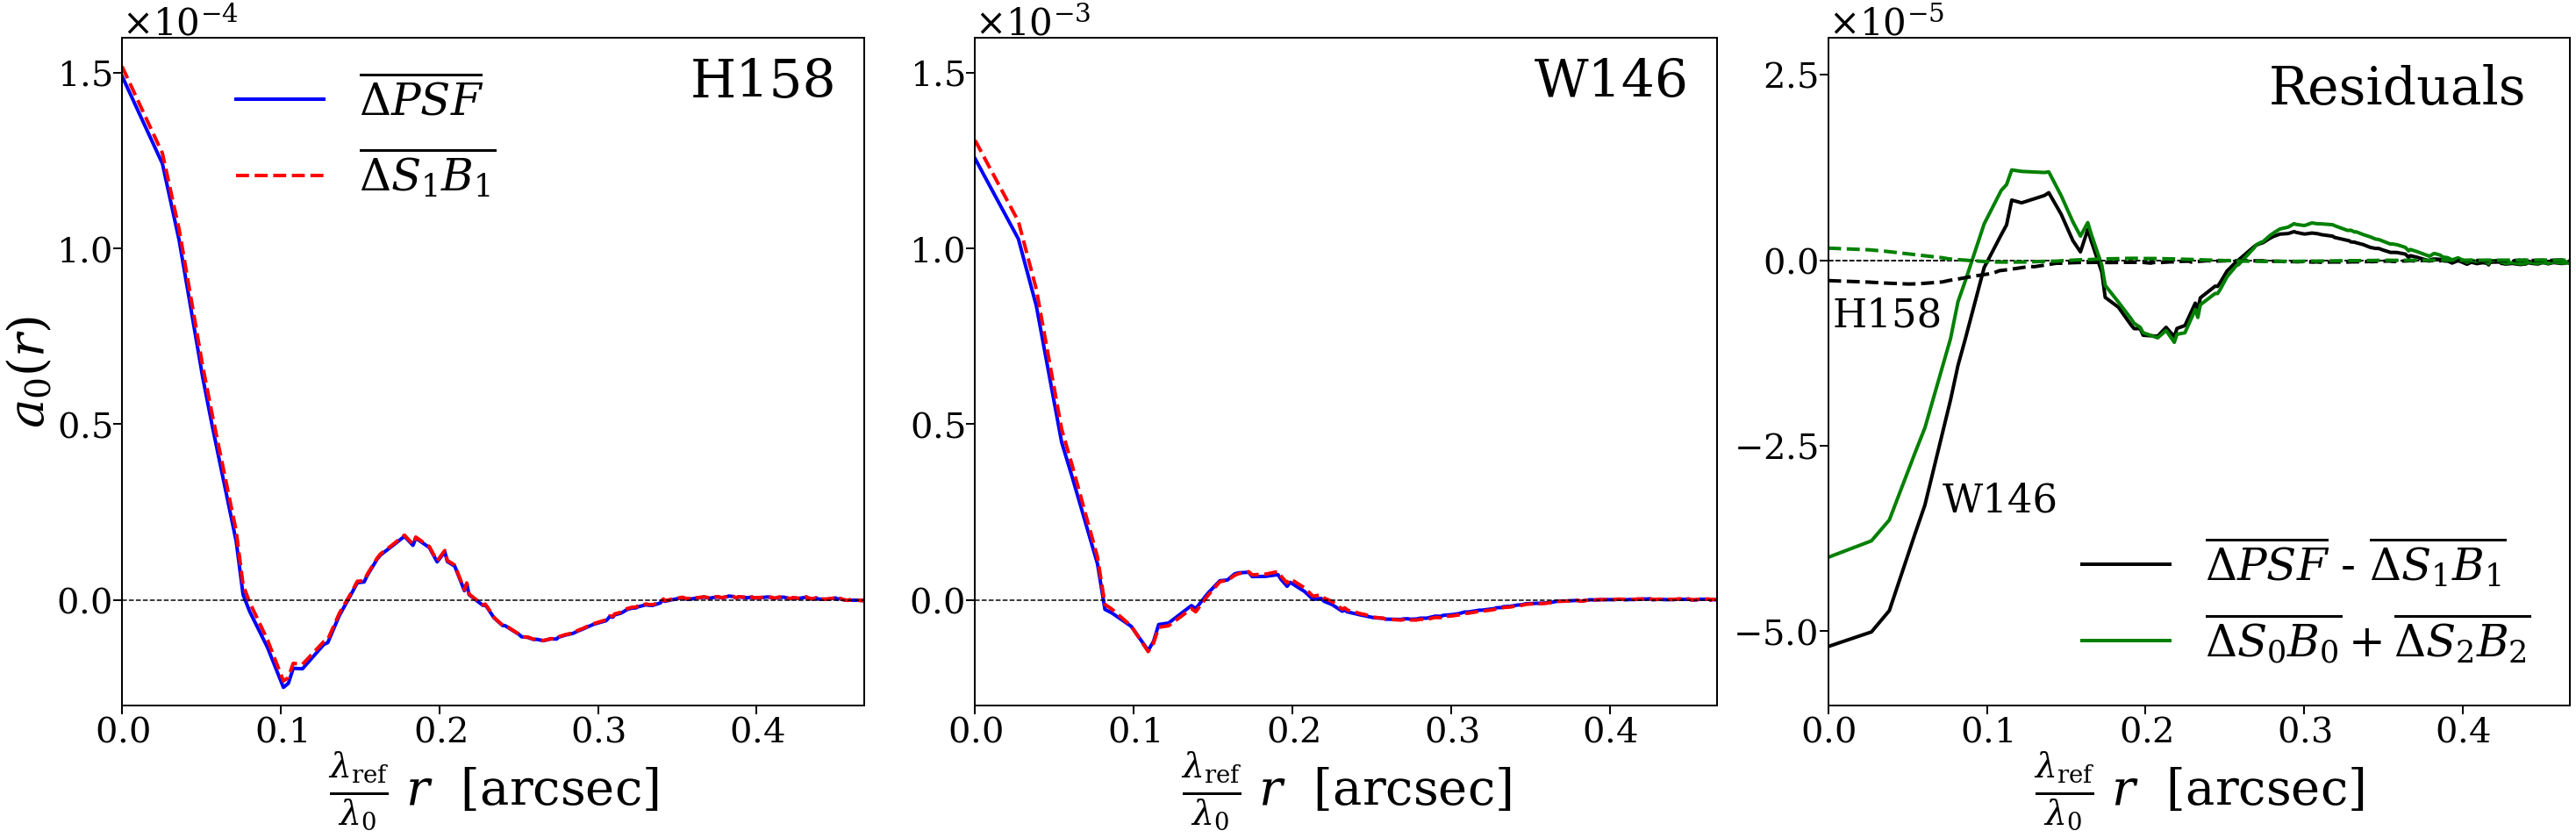

In [105]:
from matplotlib.ticker import ScalarFormatter
fig, axs = plt.subplots(figsize=(50,14), nrows=1, ncols=3, sharex=True, sharey=False)
fig.subplots_adjust(wspace=0.15, hspace=0.0)

colors = ['blue', 'orange', 'green']
#x_labels = [r'z-y',r'y-j',r'j-h',r'h-f',r'f-w', r'z-y$_s$', r'y - j$_s$',r'j-h$_s$',r'h-f$_s$',r'f-w$_s$','x', 'y', 'SCA']
#x_labels =[]
labels = ['PC 1', 'PC 2', 'PC 3']
SCA = 7
scale = roman.pixel_scale/4
lam_ratio = 1460/eff_wave
l = 0
int_str2 = r'$\overline{\Delta S_0 B_0} + \overline{\Delta S_2 B_2}$'
for i in [2,5]:
    filter_name = str(filters[i ])
    #a_0 = np.array(rad_profs_all[3*i + l +1 ])[SCAs[:1000] == SCA]
    #mean_a0 = np.mean(a_0, axis = 0)
    #std_a0 = np.std(a_0, axis = 0)/np.sqrt(len(a_0) - 1)
    img_bas = imgs_basis[filter_name][SCA - 1]
    rad_prof_r, mean_a0 = radial_profile(diff_psf[filter_name])
    #rad_prof_r, rad_prof = radial_profile(img_bas)
    rad_prof_r, rad_prof = radial_profile(corr_diff_psf[filter_name])
    rad_prof_r, rad_prof_2nd = radial_profile(corr_diff2nd_psf[filter_name])
    #img_bas_2 = imgs_basis_2[filter_name][SCA - 1]
    #rad_prof_r_2, rad_prof_2 = radial_profile(img_bas)
    #rad_prof *= np.mean(coeff_diff[filter_name][:1000])
    int_str = r'$\int \;  d\lambda \; PSF(x,y, \lambda) F(\lambda) (\lambda - \lambda_0)$'
    int_str = r'$\overline{\Delta S_1 B_1}$'
    #axs[i,j].plot(prof_t_1[0], prof_t_1[1]/np.min(prof_t_1[1]), lw = 4,color = 'red', label = int_str)
    axs[l].plot(rad_prof_r*scale*lam_ratio[i ], mean_a0, lw = 4,color = colors[0], label = r'$\overline{\Delta PSF}$')
    axs[l].plot(rad_prof_r*scale*lam_ratio[i ], rad_prof[:len(rad_prof_r)], lw = 4,ls = '--', color = 'red', label = int_str)
    
    

    #axs[i].set_title( filters[i] , fontsize = 40)
    axs[l].set_xlim(0,17*scale)
    #axs[i,j].set_ylim(-0.3,1)
    #axs[i,j].set_xscale('symlog')
    axs[l].axhline(y = 0, color = 'black', ls = '--')
    axs[l].tick_params('y', length=10, width=2, labelsize=40, which='major')
    axs[l].tick_params('x', length=10, width=2, labelsize=40, which='major')
    axs[l].yaxis.set_major_locator(plt.MaxNLocator(4))
    axs[l].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[l].ticklabel_format(axis='y', style='plain')
    axs[l].set_ylim(-3e-5,1.6e-4 )
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))  # Limits for scientific notation
    axs[l].yaxis.set_major_formatter(formatter)
    axs[l].yaxis.offsetText.set_fontsize(42)
    l +=1
    
for i in [5,2]:
    filter_name = str(filters[i ])
    #a_0 = np.array(rad_profs_all[3*i + l +1 ])[SCAs[:1000] == SCA]
    #mean_a0 = np.mean(a_0, axis = 0)
    #std_a0 = np.std(a_0, axis = 0)/np.sqrt(len(a_0) - 1)
    img_bas = imgs_basis[filter_name][SCA - 1]
    rad_prof_r, mean_a0 = radial_profile(diff_psf[filter_name])
    #rad_prof_r, rad_prof = radial_profile(img_bas)
    rad_prof_r, rad_prof = radial_profile(corr_diff_psf[filter_name])
    rad_prof_r, rad_prof_2nd = radial_profile(corr_diff2nd_psf[filter_name])
    #img_bas_2 = imgs_basis_2[filter_name][SCA - 1]
    #rad_prof_r_2, rad_prof_2 = radial_profile(img_bas)
    #rad_prof *= np.mean(coeff_diff[filter_name][:1000])
    int_str = r'$\int \;  d\lambda \; PSF(x,y, \lambda) F(\lambda) (\lambda - \lambda_0)$'
    int_str = r'$\overline{\Delta S_1 B_1}$'
    #axs[i,j].plot(prof_t_1[0], prof_t_1[1]/np.min(prof_t_1[1]), lw = 4,color = 'red', label = int_str)
    diff = mean_a0 - rad_prof[:len(rad_prof_r)]
    #axs[l].plot(rad_prof_r*scale*lam_ratio[i ], diff, lw = 4,color = 'black',label = r'$\overline{\Delta PSF}$ - ' + int_str)

    #axs[i].set_title( filters[i] , fontsize = 40)
    axs[l].set_xlim(0,17*scale)
    #axs[i,j].set_ylim(-0.3,1)
    #axs[i,j].set_xscale('symlog')
    axs[l].axhline(y = 0, color = 'black', ls = '--')
    axs[l].tick_params('y', length=10, width=2, labelsize=40, which='major')
    axs[l].tick_params('x', length=10, width=2, labelsize=40, which='major')
    axs[l].yaxis.set_major_locator(plt.MaxNLocator(4))
    axs[l].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[l].ticklabel_format(axis='y', style='plain')
    axs[l].set_ylim(-6e-5,3e-5 )
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))  # Limits for scientific notation
    axs[l].yaxis.set_major_formatter(formatter)
    axs[l].yaxis.offsetText.set_fontsize(42)
    
    rad_prof_r, rad_prof_2nd = radial_profile(corr_diff2nd_psf[filter_name])
    rad_prof02_r, rad_prof02 = radial_profile(imgs_basis_02[filter_name])
    rad_basis_02 = rad_prof_2nd#*0
    if i == 5:   
        axs[l].plot(rad_prof_r*scale*lam_ratio[i ], diff, lw = 4,color = 'black',label = r'$\overline{\Delta PSF}$ - ' + int_str)
        axs[l].plot(rad_prof_r*scale*lam_ratio[i], rad_basis_02, lw = 4,color = 'green', label = int_str2)
        axs[2].legend(loc = 'lower right', frameon = False, fontsize = 50)

    else:
        axs[l].plot(rad_prof_r*scale*lam_ratio[i ], diff, lw = 4,color = 'black',ls = '--', label = r'$\overline{\Delta PSF}$ - ' + int_str)
        axs[l].plot(rad_prof_r*scale*lam_ratio[i], rad_basis_02, lw = 4,ls = '--', color = 'green', label = int_str2)
axs[1].set_ylim(-3e-4,1.6e-3)
axs[0].text(0.45, 1.4*1e-4, 'H158', fontsize=60, verticalalignment='bottom', horizontalalignment='right')
axs[1].text(0.45, 1.4*1e-3, 'W146', fontsize=60, verticalalignment='bottom', horizontalalignment='right')

axs[2].text(0.44, 1.4*1.4e-5, 'Residuals', fontsize=60, verticalalignment='bottom', horizontalalignment='right')
axs[2].text(0.072, -10e-6, 'H158', fontsize=45, verticalalignment='bottom', horizontalalignment='right')
axs[2].text(0.145, -3.5*1e-5, 'W146', fontsize=45, verticalalignment='bottom', horizontalalignment='right')

axs[0].set_ylabel(r'$a_0 (r)$', fontsize = 56)
axs[0].set_xlabel(r'$\frac{\lambda_{\text{ref}}}{\lambda_{0}}\; r $  [arcsec]', fontsize = 56)
axs[1].set_xlabel(r'$\frac{\lambda_{\text{ref}}}{\lambda_{0}}\; r $  [arcsec]', fontsize = 56)
axs[2].set_xlabel(r'$\frac{\lambda_{\text{ref}}}{\lambda_{0}}\; r $  [arcsec]', fontsize = 56)
#axs[3].set_xlabel(r'$\frac{\lambda_0}{\lambda_{eff}}\; r $  [arcsec]', fontsize = 50)
axs[0].legend(loc = 'upper left', frameon = False, fontsize = 50, bbox_to_anchor=(0.1,1.0))

save = True
if save:
    plt.savefig('PaperFigures/a0basis.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Analysis of PSF from zbin avg

In [289]:
diff_psf = {}
corr_diff_psf = {}
corr_diff2nd_psf = {}
for filter_name in use_filters:
    diff_img = np.zeros(avg_star_psf_0[filter_name][0].shape)
    corr_diff_img = np.zeros(avg_star_psf_0[filter_name][0].shape)
    corr_diff2nd_img = np.zeros(avg_star_psf_0[filter_name][0].shape)
    num_ = len(avg_star_psf_0[filter_name])
    mean_filt_all = np.mean(coeff_diff[filter_name])
    coeff_z_mean = []
    coeff_z_mean_each = []
    for j in range(0,5):
        mask = np.logical_and(z_diffsky > z_bins[j], z_diffsky< z_bins[j + 1])
        #mask = np.logical_and(photoz_test > z_bins[j], photoz_test < z_bins[j + 1])

        coeff_z_mean.append(np.mean(coeff_diff[filter_name][mask]))
    for i in range(num_):
        for j in range(0,5):
            mask = np.logical_and(z_diffsky[i] > z_bins[j], z_diffsky[i] < z_bins[j + 1])
            #mask = np.logical_and(photoz_test[i+ add_idx] > z_bins[j], photoz_test[i+ add_idx] < z_bins[j + 1])
            if mask:
                mean_filt = np.mean(coeff_z_mean[j])
        star_img_test =avg_star_psf_0[filter_name][i].copy()
        star_img_test/= np.sum(star_img_test)
        
        gal_img_test =avg_true_psf_0[filter_name][i].copy()
        gal_img_test/= np.sum(gal_img_test)
        #corr_img = star_img_test - imgs_basis['H158'][0]*coeff_all['H158'][0]
        
        #if filter_name == 'Z087':
        #    corr_img = star_img_test
        #else:
        coeff_z_mean_each.append(mean_filt)
        if (z_diffsky[i] > z_bins[4] and z_diffsky[i] < z_bins[4+1]):
            temp_img =  star_img_test - imgs_basis[filter_name][SCAs[i] - 1]*(mean_filt)
            corr_diff_img += temp_img/np.sum(temp_img)
            #corr_diff_img += imgs_basis[filter_name][0]*coeff_diff[filter_name][i]
            #corr_diff2nd_img += (norm0*imgs_basis2[filter_name][SCAs[i] - 1] - norm2*imgs_basis0[filter_name][SCAs[i] - 1])*coeff_diff_2nd_[filter_name][i]
            #corr_diff2nd_img += (imgs_basis0[filter_name][SCAs[i] - 1])*coeff_diff_0th[filter_name][i]
            #corr_diff2nd_img -= (imgs_basis[filter_name][SCAs[i] - 1])*(coeff_diff[filter_name][i] - coeff_diff_[filter_name][i])
            #corr_diff2nd_img += imgs_basis3[filter_name][SCAs[i] - 1]*coeff_diff_3rd[filter_name][i]
            diff_img +=  gal_img_test
        #corr_img = star_img_test - imgs_basis[filter_name][SCAs[i] - 1]*coeff_all[filter_name][i] - imgs_basis_2[filter_name][SCAs[i] - 1]*coeff2_all[filter_name][i]
        #corr_img = star_img_test - imgs_basis[filter_name][SCAs[i] - 1]*mean_filt
    diff_psf[filter_name] = diff_img/num_
    corr_diff_psf[filter_name] = corr_diff_img/num_
    print(np.mean(coeff_z_mean_each), mean_filt_all)
    #corr_diff2nd_psf[filter_name] = corr_diff2nd_img/num_

-6.091177872630449e-06 -6.137281629117251e-06
-3.1408022003713185e-06 -3.2122919309534646e-06
-2.353714432533454e-06 -2.3588711476406856e-06
-4.418037818636181e-06 -4.471671376606974e-06
-1.0200795087910498e-06 -1.0321440052899636e-06


## PSF plot

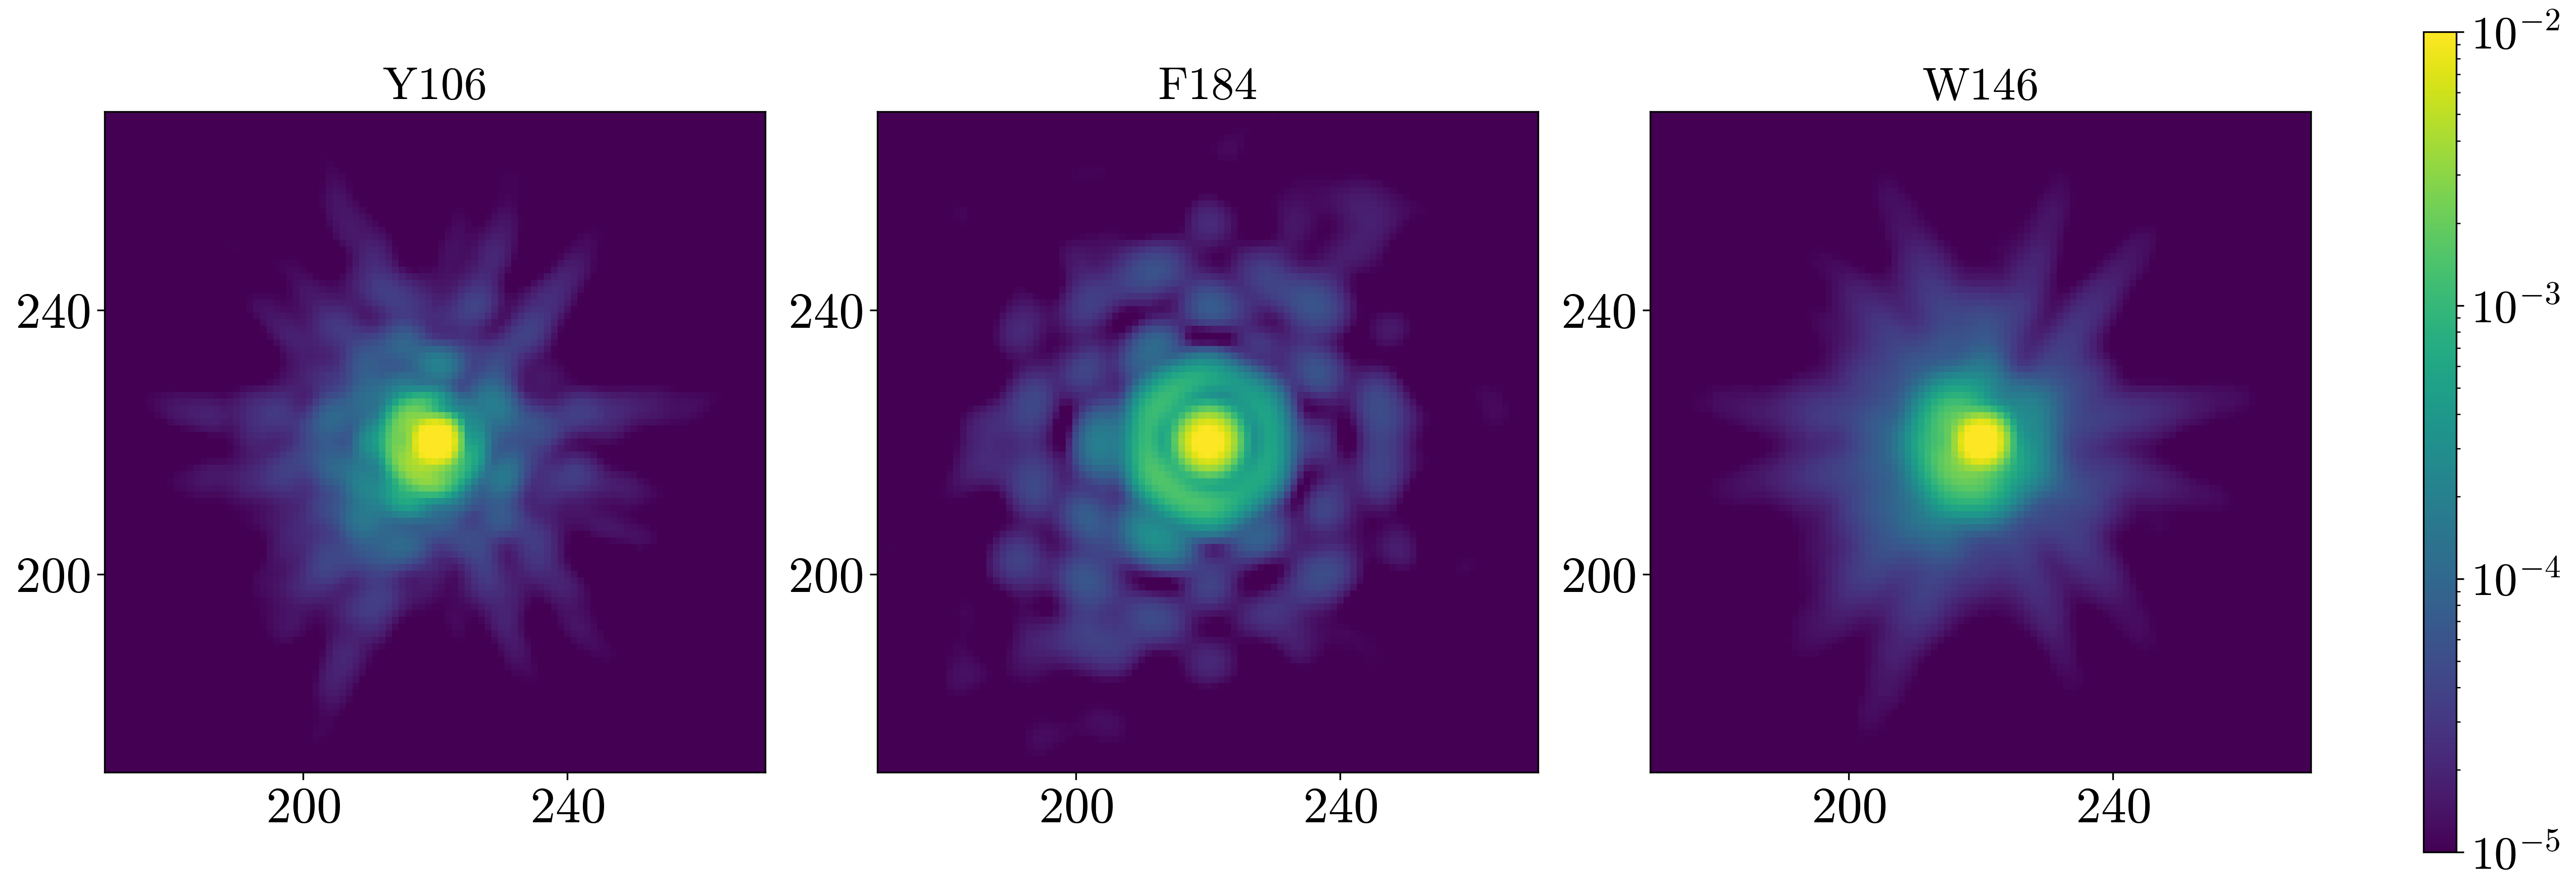

In [320]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
# Get all keys and select the ones you want
keys_to_plot = list(avg_star_psf_0.keys())
keys_to_plot = [keys_to_plot[0], keys_to_plot[3], keys_to_plot[4]]  # First, Fifth, and Sixth

# Set up the figure and GridSpec for a 1x4 grid (3 panels + colorbar)
fig = plt.figure(figsize=(18, 6), dpi=300)
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])

# Define the common normalization
norm = LogNorm(vmin=1e-5, vmax=1e-2)

# Iterate over the selected keys
for i, key in enumerate(keys_to_plot):
    ax = fig.add_subplot(gs[i])
    images = avg_star_psf_0[key]
    img = images[0].copy()
    img[img < 0] = img[img < 0] * -1e-1
    img = img / np.sum(img)
    # Plot the image with common logarithmic normalization
    im = ax.imshow(img, cmap='viridis', norm=norm)
    # Set the title of the subplot to the key
    ax.set_title(key, fontsize=22)
    # Set limits and formatting
    ax.set_xlim(170, 270)
    ax.set_ylim(170, 270)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

# Add a single colorbar for the entire figure on the right
cbar_ax = fig.add_subplot(gs[:, 3])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=22)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the right margin to fit colorbar

# Show plot
plt.show()

In [397]:
## calculate convergance

In [406]:
batches = ['0_999', '1000_1999', '2000_2999','3000_3999','4000_4999','5000_5999','6000_6999','7000_7999', '8000_8999', '9000_9999']
scale = roman.pixel_scale/4
size_true = []
size_star = []
for batch in batches:
    _, avg_true_psf_batch, avg_star_psf_batch = get_data(root_dir,shear_str = '0', batch = batch, return_gal =False)
    for i in range(len(avg_true_psf_batch['H158'])):
        img_str = galsim.Image(avg_true_psf_batch['H158'][i])
        mom_true = galsim.hsm.FindAdaptiveMom(img_str, strict = False)
        size_true.append(mom_true.moments_sigma*scale)

        img_str = galsim.Image(avg_star_psf_batch['H158'][i])
        mom_star = galsim.hsm.FindAdaptiveMom(img_str, strict = False)
        size_star.append(mom_star.moments_sigma*scale)
size_true = np.array(size_true)
size_star = np.array(size_star)

In [451]:
frac_size_diff = size_star/size_true - 1
size_conv = []
for i in range(100,len(frac_size_diff), 1):
    size_conv.append(np.mean(frac_size_diff[:i]))
size_conv = np.array(size_conv )

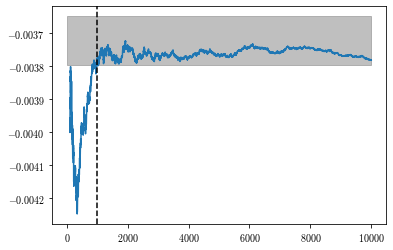

In [475]:
plt.plot(np.arange(100,len(frac_size_diff)),size_conv)
plt.fill_between([0,10000], y1 =np.max(size_conv)*(0.98), y2 =np.max(size_conv)*(1.02), color = 'grey', alpha = 0.5 )
plt.axvline(x = 1000, color = 'black', ls = '--' )
plt.show()

In [466]:
def find_convergence(values, tolerance=0.01, window=1):
    """
    Determines the index where the values array converges within a given tolerance.
    
    Parameters:
        values (array-like): The input array of values.
        tolerance (float): The convergence threshold as a fraction (default is 0.01 for 1%).
        window (int): The number of consecutive steps that must satisfy the condition to confirm convergence (default is 1).
    
    Returns:
        int: The index where convergence starts, or -1 if convergence is not achieved.
    """
    # Convert to a NumPy array for easier manipulation
    values = np.array(values)
    
    # Calculate the relative difference between successive values
    differences = np.abs(np.diff(values))
    relative_differences = differences / values[:-1]
    
    # Find where the relative differences are less than the tolerance
    convergence_mask = relative_differences < tolerance
    
    # Check for sustained convergence over the specified window
    for i in range(len(convergence_mask) - window + 1):
        if np.all(convergence_mask[i:i + window]):
            return i + window  # Return the index after the sustained period
    
    return -1  # Return -1 if convergence is not found

# Example usage
values = [100, 95, 90.1, 90.05, 90.01, 90.001, 90.0005]
convergence_index = find_convergence(size_conv, tolerance=0.0001, window=30)

if convergence_index != -1:
    print(f"Convergence starts at index {convergence_index}, value: {size_conv[convergence_index]}")
else:
    print("Convergence not achieved within the array.")

Convergence starts at index 30, value: -0.003902703760243084


In [469]:
size_conv[0]/size_conv[29] - 1

0.022768249450134004